# SYNTHETIC DATASET PARAMETER ESTIMATION FOR ALL CARMENES GTO OBJECTS

**IMPORTANT NOTE:** This notebook is almos similar the same as the previous one (SyntheticDataset_05_Parameter_estimation), but applied to all the RV curves in the CARMENES GTO pool (i.e. 363 objects - indeed 355 objects after discarding the objects that gave trouble during periodogram calculation - instead of 239 objects). Some minor changes apply, though:
- Some `nan` and other incorrect values were detected is some of the variables, so it was necessary to drop them before fitting the distributions.

Each noiseless, synthetic sample will be generated by means of a sinusoidal function, in the form:

$$x(t)=A\cos\{2\pi(\nu(t-\tau)+\delta)\}+c$$

With:
- $A:\:amplitude\:of\:the\:signal$
- $\nu:\:frequency\:of\:the\:signal$
- $\tau:\:reference\:epoch$
- $\delta:\:phase\:of\:the\:signal$
- $c:\: offset$

Initially, we will need these typical basic parameters to generate the basic, noiseless sinusoidal curves that simulate the pulsation of the stars.
- Amplitude: given by theoretical calculations, with the predicted range for M-dwarf stars.
- Frequency: given by theoretical calculations, with the predicted range for M-dwarf stars.
- Reference epoch: will be taken randomly (uniform distribution) from the full time span of the real datasets.
- Phase: random value (uniform distribution), $\delta\in[0, 1)$.
- Offset: will be taken randomly from the estimated distributionof values in the real datasets.

**IMPORTANT NOTE: SHOULD AMPLITUDES AND FREQUENCIES BE SOMEHOW RELATED FOR THE TESS AND CARMENES SAMPLES THAT WILL BE CREATED FROM THE BASIC, NOISELESS SAMPLE?**

Additionally, the ideal curves will be generated under two important conditions: first, their sampling frequency must be high enough for periodograms to be able to extract the frequency of the sinusoid; second, the number of points in the time series must be high enough to cover a number of the expected complete periods. The underlaying idea is that the periodogram is able to extract the information from the time series without trouble, so that this initial result serves as a benchmark for later, noisy and impeerfectly sampled time series.

We need to extract the statistical distributions of the parameters for the real curves (CARMENES RV curves and TESS light curves) in order to later apply some parameters on top of the ideal synthetic dataset to be created. The parameters of the real time series to be explored include:
- Offset (mean value) of the time series. Its distribution should define the random offset ($c$ value) for the noiseless samples.
- RMS of the time series curves: this will define a distribution for the noise to apply to the ideal, noiseless synthetic periodic signals.
- Sampling frequency/period: this will define a distribution of sampling period.
- Number of samples: this will define the number of points to be taken from the ideal, synthetic dataset.
- Overall period of time (for all the real dataset): this will define the range of reference epoch values allowed for the synthetic time series.

Notice that for both groups of parameters the values obtained for CARMENES and for TESS datasets will be different from each other.


## Modules and configuration

### Modules

In [1]:
import pandas as pd
import numpy as np

import lightkurve as lk

from scipy.stats import normaltest, ttest_ind, pearsonr

import numbers

from distfit import distfit

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white", {'figure.figsize':(15,10)})

### Configuration

In [2]:
# CONFIGURATION:
GTO_FILE = "../data/GTO_objects_with_PG.csv" # The file containing all the 363 CARMENES GTO objects.
GTO_OBJECTS_TO_DROP = []

IMAGE_FOLDER = "./img/"

DIST_FILES_FOLDER = "./DIST_FILES/"
DIST_SUMMARY_FILE = "./DIST_FILES/Parameter_distributions_All_GTO.csv" # A new file.

RANDOM_STATE = 11 # For reproducibility

# STATISTICAL CONSTANTS:
SIGMAS = 3.0 # Number of sigmas above which to discard outliers.
LOW_PC = 1.0 # Lower percentile (%) to discard possible outliers by percentile method.
HIGH_PC = 99.0 # Higher percentile (%) to discard possible outliers by percentile method.
ALPHA = 1e-3 # Significance threshold for statistical tests

### Functions

In [3]:
def discard_outliers_sigma(x, n_sigmas):
    '''Discard outliers from a list using n_sigma-based approach'''
    x_mean = np.nanmean(x)
    x_std = np.nanstd(x)
    x_low = x_mean - n_sigmas * x_std
    x_high = x_mean + n_sigmas * x_std
    filtered_x = [i for i in x if i >= x_low and i <= x_high]
    return filtered_x

In [4]:
def discard_outliers_pc(x, low_pc, high_pc):
    '''Discard outliers from a list using a percentile-based approach'''
    x_low = np.nanpercentile(x, low_pc)
    x_high = np.nanpercentile(x, high_pc)
    filtered_x = [i for i in x if i >= x_low and i <= x_high]
    return filtered_x

In [5]:
def draw_hist(d1, d1_label, fig_filename=None):
    '''Draws an histogram of the values passed. It also calulates the statistics
    and tests the goodness of fit by a Gaussian distribution'''
    # Plots and saves the figure
    kwargs = dict(hist_kws={'alpha':.4}, kde_kws={'linewidth':2})
    plt.figure(figsize=(10,7))
    plt.title(d1_label + " values distribution", fontsize=16)
    plt.grid(axis='x', alpha=0.75)
    plt.xlabel(d1_label, fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    sns.distplot(d1, label=d1_label, **kwargs)
    #sns.histplot(d1, label=d1_label)
    #plt.xlim(0,100)
    #plt.legend(loc='upper right');
    # Save the image:
    if fig_filename is None:
        pass
    else:
        plt.savefig(fig_filename, format='png')
    # Display basic statistics:
    print(pd.Series(d1).describe())
    # Perform the normaltest (D'Agostino and Pearson) for Gaussian distribution fit:
    k2, p = normaltest(d1)
    alpha = ALPHA
    print("p = {:g}".format(p))
    if p < alpha:  # null hypothesis: x comes from a normal distribution
        print("***This distribution does NOT come from a Gaussian distribution" \
              "(with significance level = %.6f)" %(1.0 - alpha))
    else:
        print("This distribution MIGHT COME come from Gaussian distribution" \
              "(with significance level = %.6f)" %(1.0 - alpha))

In [6]:
def compare_dist(d1, d2, d1_label, d2_label, varname=None, fig_title=None, fig_filename=None):
    '''Plots and saves overlapped histograms.
    It also shows the result of a t-Student test.'''
    # Plots and saves the figure
    kwargs = dict(hist_kws={'alpha':.4}, kde_kws={'linewidth':2})
    plt.figure(figsize=(10,7))
    if fig_title is None:
        plt.title("Comparison of distributions", fontsize=16)
    else:
        plt.title(fig_title, fontsize=16)
    plt.grid(axis='x', alpha=0.75)
    if varname is None:
        plt.xlabel("%s / %s" %(d1_label, d2_label), fontsize=12)
    else:
        plt.xlabel(varname, fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    sns.distplot(d1, label=d1_label, **kwargs)
    sns.distplot(d2, label=d2_label, **kwargs)
    #plt.xlim(0,100)
    plt.legend(loc='upper right');
    # Save the image:
    if fig_filename is None:
        pass
    else:
        plt.savefig(fig_filename, format='png')
    # Perform the t-Student test (as independent samples):
    stat, p = ttest_ind(d1, d2)
    print('stat=%.3f, p=%.3f' % (stat, p))
    if p > 0.05:
        print('Probably the same distribution')
    else:
        print('***Probably different distributions')

In [7]:
def scatter_graph(data, var_x, var_y, fig_filename=None):
    '''Plots a scatter plot of two columns of a dataframe.
    It also calculates and shows Pearson's correlation coefficient.'''
    #rv_x_var = var_x
    #tess_y_var = var_y
    #kwargs = dict(hist_kws={'alpha':.4}, kde_kws={'linewidth':2})
    plt.figure(figsize=(10,7))
    plt.title(var_y + " vs " + var_x, fontsize=16)
    plt.grid(axis='both', alpha=0.75)
    plt.xlabel(var_x, fontsize=12)
    plt.ylabel(var_y, fontsize=12)
    sns.scatterplot(data=data, x=var_x, y=var_y)
#    plt.xlim(0.0, 1.0)
#    plt.ylim(0.0, 1.0)    
    plt.legend(loc='upper right');
    # Save the image:
    if fig_filename is None:
        pass
    else:
        plt.savefig(fig_filename, format='png')
    # Calculate the Pearson correlation coefficient between the two results:
    corr, _ = pearsonr(data[var_x], data[var_y])
    print('Pearson\'s correlation value: %.3f' % corr)

In [8]:
def update_distributions(dist_df, group, variable, dist):
    group = "BENCHMARK"
    variable = "refepochRV"
    d_model = dist.model
    filename = group + "_" + variable +"_All_GTO_dist.pickle"
    dist_df = dist_df.append({'Group': group,
                            'Variable': variable,
                            'Distribution': d_model,
                            'Dist_file': filename}, ignore_index=True)
    if filename is None:
        pass
    else:
        dist.save(DIST_FILES_FOLDER + filename)
    dist_df.to_csv(DIST_SUMMARY_FILE, sep=',', decimal='.', index=False)
    return dist_df

In [9]:
def tess_lc_load(filename: str):
    '''Load the TESS LC file and returns a lightcurve object with just the three relevant columns
    Note: it seems to be necessary to drop 'nan' values for GLS to work properly.'''
    lc_lk = lk.read(filename).remove_nans()
    return lc_lk

## Load the GTO objects information

It will be needed to calculate stats for the synthetic dataset paremeters.

In [10]:
gto = pd.read_csv(GTO_FILE, sep=',', decimal='.')
gto.head()

,Karmn,Name,Comp,GJ,RA_J2016_deg,DE_J2016_deg,RA_J2000,DE_J2000,l_J2016_deg,b_J2016_deg,...,T0_PG_TESS,e_T0_PG_TESS,offset_PG_TESS,e_offset_PG_TESS,FAP_PG_TESS,valid_PG_TESS,error_PG_TESS,elapsed_time_PG_TESS,fits_file_TESS,fig_file_TESS
0,J23585+076,Wolf 1051,AB,4383,359.636420,7.656947,23:58:32.65,+07:39:30.1,100.839686,-52.931049,...,NaN,NaN,NaN,NaN,NaN,0.0,Not recognized as a supported data product:\nn...,0.002199,NaN,NaN
1,J23556-061,GJ 912,AB,912,358.913617,-6.144283,23:55:39.78,-06:08:33.4,88.129933,-65.175491,...,NaN,NaN,NaN,NaN,NaN,0.0,Not recognized as a supported data product:\nn...,0.000974,NaN,NaN
2,J23548+385,RX J2354.8+3831,-,NaN,358.713658,38.526340,23:54:51.46,+38:31:36.2,110.941908,-23.024449,...,1764.609498,0.010704,8262.219751,1.365667,1.000000,1.0,NaN,344.002685,../data/CARMENES_GTO_TESS_PGs/J23548+385_TESS_...,../data/CARMENES_GTO_TESS_PGs/figures/J23548+3...
3,J23505-095,LP 763-012,-,4367,357.634705,-9.560964,23:50:31.64,-09:33:32.7,80.777067,-67.303426,...,1354.108815,0.001261,7767.134654,0.094298,0.064148,1.0,NaN,473.533042,../data/CARMENES_GTO_TESS_PGs/J23505-095_TESS_...,../data/CARMENES_GTO_TESS_PGs/figures/J23505-0...
4,J23492+024,BR Psc,-,908,357.306604,2.396918,23:49:12.53,+02:24:04.4,93.567467,-56.885396,...,NaN,NaN,NaN,NaN,NaN,0.0,Not recognized as a supported data product:\nn...,0.000984,NaN,NaN


In [11]:
gto.shape

(363, 248)

We have here all the 363 CARMENES GTO objects.

In [12]:
print(list(gto.columns))

['Karmn', 'Name', 'Comp', 'GJ', 'RA_J2016_deg', 'DE_J2016_deg', 'RA_J2000', 'DE_J2000', 'l_J2016_deg', 'b_J2016_deg', 'Ref01', 'SpT', 'SpTnum', 'Ref02', 'Teff_K', 'eTeff_K', 'logg', 'elogg', '[Fe/H]', 'e[Fe/H]', 'Ref03', 'L_Lsol', 'eL_Lsol', 'Ref04', 'R_Rsol', 'eR_Rsol', 'Ref05', 'M_Msol', 'eM_Msol', 'Ref06', 'muRA_masa-1', 'emuRA_masa-1', 'muDE_masa-1', 'emuDE_masa-1', 'Ref07', 'pi_mas', 'epi_mas', 'Ref08', 'd_pc', 'ed_pc', 'Ref09', 'Vr_kms-1', 'eVr_kms-1', 'Ref10', 'ruwe', 'Ref11', 'U_kms-1', 'eU_kms-1', 'V_kms-1', 'eV_kms-1', 'W_kms-1', 'eW_kms-1', 'Ref12', 'sa_m/s/a', 'esa_m/s/a', 'Ref13', 'SKG', 'Ref14', 'SKG_lit', 'Ref14_lit', 'Pop', 'Ref15', 'vsini_flag', 'vsini_kms-1', 'evsini_kms-1', 'Ref16', 'P_d', 'eP_d', 'Ref17', 'pEWHalpha_A', 'epEWHalpha_A', 'Ref18', 'log(LHalpha/Lbol)', 'elog(LHalpha/Lbol)', 'Ref19', '1RXS', 'CRT_s-1', 'eCRT_s-1', 'HR1', 'eHR1', 'HR2', 'eHR2', 'Flux_X_E-13_ergcm-2s-1', 'eFlux_X_E-13_ergcm-2s-1', 'LX/LJ', 'eLX/LJ', 'Ref20', 'Activity', 'Ref21', 'FUV_mag',

### Clean the object list

To be on the safe side, we remove the objects that gave trouble during the RV periodogram calculations:

In [13]:
gto.loc[gto['valid_PG_RV'] == 0, 'Karmn']

92     J17572+707
99     J17198+417
115    J16102-193
260    J07051-101
270    J06318+414
273    J06103+821
309    J04173+088
344    J01352-072
Name: Karmn, dtype: object

In [14]:
gto = gto[gto['valid_PG_RV'] == 1].reset_index().copy()
gto.head()

,index,Karmn,Name,Comp,GJ,RA_J2016_deg,DE_J2016_deg,RA_J2000,DE_J2000,l_J2016_deg,...,T0_PG_TESS,e_T0_PG_TESS,offset_PG_TESS,e_offset_PG_TESS,FAP_PG_TESS,valid_PG_TESS,error_PG_TESS,elapsed_time_PG_TESS,fits_file_TESS,fig_file_TESS
0,0,J23585+076,Wolf 1051,AB,4383,359.636420,7.656947,23:58:32.65,+07:39:30.1,100.839686,...,NaN,NaN,NaN,NaN,NaN,0.0,Not recognized as a supported data product:\nn...,0.002199,NaN,NaN
1,1,J23556-061,GJ 912,AB,912,358.913617,-6.144283,23:55:39.78,-06:08:33.4,88.129933,...,NaN,NaN,NaN,NaN,NaN,0.0,Not recognized as a supported data product:\nn...,0.000974,NaN,NaN
2,2,J23548+385,RX J2354.8+3831,-,NaN,358.713658,38.526340,23:54:51.46,+38:31:36.2,110.941908,...,1764.609498,0.010704,8262.219751,1.365667,1.000000,1.0,NaN,344.002685,../data/CARMENES_GTO_TESS_PGs/J23548+385_TESS_...,../data/CARMENES_GTO_TESS_PGs/figures/J23548+3...
3,3,J23505-095,LP 763-012,-,4367,357.634705,-9.560964,23:50:31.64,-09:33:32.7,80.777067,...,1354.108815,0.001261,7767.134654,0.094298,0.064148,1.0,NaN,473.533042,../data/CARMENES_GTO_TESS_PGs/J23505-095_TESS_...,../data/CARMENES_GTO_TESS_PGs/figures/J23505-0...
4,4,J23492+024,BR Psc,-,908,357.306604,2.396918,23:49:12.53,+02:24:04.4,93.567467,...,NaN,NaN,NaN,NaN,NaN,0.0,Not recognized as a supported data product:\nn...,0.000984,NaN,NaN


In [15]:
gto.shape

(355, 249)

355 objects remain.

## Synthetic dataset parameter definition

We first initialize the result DataFrame to store the information on all the distributions

In [16]:
fit_dist = pd.DataFrame(columns=['Group', 'Variable', 'Distribution', 'Dist_file'])
fit_dist

,Group,Variable,Distribution,Dist_file


In [17]:
fit_dist.dtypes

Group           object
Variable        object
Distribution    object
Dist_file       object
dtype: object

In [18]:
fit_dist.to_csv(DIST_SUMMARY_FILE, sep=',', decimal='.', index=False)

### Common to both RV and photometric curves

**Note:** we have decided to keep the basic parameters of sampling and time of observation equal for all synthetic samples, no matter which their oscillation frequencies are. For this reason, different records will contain different numbers of complete periods of the signal.

#### Minimum sampling frequency for benchmark dataset

The sampling frequency must be compliant with the basic Nyquist criterion:

$$f_{sampling}\geq2f_{max}$$

The maximum frequency ($f_{max}$) corresponds to the inverse of the minimum period we are looking for. Recall that the pulsation periods we were looking for were in the range $P\in[0.006944, 0.208333] d$ or, equivalently, frequencies in the range $f\in[144, 4.8] d^{-1}$. Hence, the sampling of the benchmark dataset must be:

$$f_{sampling}\geq2\times144\:d^{-1}=288\:d^{-1}$$

Or, equivalently, the samples must be spaced apart no greater than:

$$\Delta t\leq\frac{1}{f_{sampling}}=\frac{1}{288}\approx0.0034\:d$$


#### Minimum time of observation for benchmark dataset

For the length of the benchmark time series we will choose a value that covers two complete periods of the signal with the lowest possible frequency to be searched for:

$$T_{obs}=2\times\frac{1}{f_{min}}=2\times\frac{1}{4.8}\approx0.208333\:d$$

**CONCLUSION:** complyant with both conditionts, we choose a separation between samples of $0.0025\:d$ and an _observation time_ of $0.25\:d$, to keep the figures simplicity and to have just $101$ points on each time series:

$$\Delta t=0.0025\:d$$

$$T_{obs}=0.25\:d$$


Hence, we can record our two first distributions in our summary.

In [19]:
group = "BENCHMARK"
variable = "Ps"
d_model = dict({'fixed_value': 0.0025}) # Special mode meaning "fixed value" (no distribution file is saved)
dist_to_save = None
filename = None
fit_dist = fit_dist.append({'Group': group,
                            'Variable': variable,
                            'Distribution': d_model,
                            'Dist_file': filename}, ignore_index=True)
if filename is None:
    pass
else:
    dist_to_save.save(DIST_FILES_FOLDER + filename)
fit_dist.to_csv(DIST_SUMMARY_FILE, sep=',', decimal='.', index=False)

In [20]:
group = "BENCHMARK"
variable = "Tobs"
d_model = dict({'fixed_value': 0.25}) # Special mode meaning "fixed value" (no distribution file is saved)
dist_to_save = None
filename = None
fit_dist = fit_dist.append({'Group': group,
                            'Variable': variable,
                            'Distribution': d_model,
                            'Dist_file': filename}, ignore_index=True)
if filename is None:
    pass
else:
    dist_to_save.save(DIST_FILES_FOLDER + filename)
fit_dist.to_csv(DIST_SUMMARY_FILE, sep=',', decimal='.', index=False)

In [21]:
fit_dist

,Group,Variable,Distribution,Dist_file
0,BENCHMARK,Ps,{'fixed_value': 0.0025},None
1,BENCHMARK,Tobs,{'fixed_value': 0.25},None


#### Frequency range of pure sinusoidal signals (theoretical)

This is just the range of the expected frequencies to find in the $He^{3}$-burning instability band. The periods range from $20\:min$ to $4\:h$ (i.e. $0.013888-0.166667\:d$), so the frequencies will have a range of:

$$f\in[6.0, 72.0]\:d^{-1}$$

Without any further information, we will be assuming a _**uniform distribution**_ for the frequencies to be generated. We generate and save it.

In [22]:
group = "BENCHMARK"
variable = "frequency"
dist_to_save = distfit(distr='uniform')
dist_to_save.fit_transform(pd.Series([6.0, 72.0]))
d_model = dist_to_save.model
filename = group + "_" + variable +"_All_GTO_dist.pickle"
fit_dist = fit_dist.append({'Group': group,
                            'Variable': variable,
                            'Distribution': d_model,
                            'Dist_file': filename}, ignore_index=True)
if filename is None:
    pass
else:
    dist_to_save.save(DIST_FILES_FOLDER + filename)
fit_dist.to_csv(DIST_SUMMARY_FILE, sep=',', decimal='.', index=False)

[distfit] >fit..
[distfit] >transform..
[distfit] >[uniform] [0.00 sec] [RSS: 0.2754821] [loc=6.000 scale=66.000]
[distfit] >Compute confidence interval [parametric]
[pypickle] Pickle file saved: [./DIST_FILES/BENCHMARK_frequency_All_GTO_dist.pickle]
[distfit] >Saving.. True


In [23]:
fit_dist

,Group,Variable,Distribution,Dist_file
0,BENCHMARK,Ps,{'fixed_value': 0.0025},None
1,BENCHMARK,Tobs,{'fixed_value': 0.25},None
2,BENCHMARK,frequency,{'distr': <scipy.stats._continuous_distns.unif...,BENCHMARK_frequency_All_GTO_dist.pickle


#### Phase range for light curves

This will be just a simple, _**uniform distribution**_ between 0 and 1.

$$\delta\in[0.0, 1.0)$$


In [24]:
group = "BENCHMARK"
variable = "phase"
dist_to_save = distfit(distr='uniform')
dist_to_save.fit_transform(pd.Series([0.0, 1.0]))
d_model = dist_to_save.model
filename = group + "_" + variable +"_All_GTO_dist.pickle"
fit_dist = fit_dist.append({'Group': group,
                            'Variable': variable,
                            'Distribution': d_model,
                            'Dist_file': filename}, ignore_index=True)
if filename is None:
    pass
else:
    dist_to_save.save(DIST_FILES_FOLDER + filename)
fit_dist.to_csv(DIST_SUMMARY_FILE, sep=',', decimal='.', index=False)

[distfit] >fit..
[distfit] >transform..
[distfit] >[uniform] [0.00 sec] [RSS: 1200.0000000] [loc=0.000 scale=1.000]
[distfit] >Compute confidence interval [parametric]
[pypickle] Pickle file saved: [./DIST_FILES/BENCHMARK_phase_All_GTO_dist.pickle]
[distfit] >Saving.. True


In [25]:
fit_dist

,Group,Variable,Distribution,Dist_file
0,BENCHMARK,Ps,{'fixed_value': 0.0025},None
1,BENCHMARK,Tobs,{'fixed_value': 0.25},None
2,BENCHMARK,frequency,{'distr': <scipy.stats._continuous_distns.unif...,BENCHMARK_frequency_All_GTO_dist.pickle
3,BENCHMARK,phase,{'distr': <scipy.stats._continuous_distns.unif...,BENCHMARK_phase_All_GTO_dist.pickle


### CARMENES RV curves stats

In [26]:
# Initialize lists:
rv_offsets = []
rv_epochs = []
rv_rms = []
# Add all relevant values
#for i in range(0, 5):
for i in range(0, len(gto)):
    # Update offset list:
    rv_offsets.append(gto.loc[i, 'wmean_RV'])
    # Read the original RV time series of the object.
    rv_ts = pd.read_csv(gto.loc[i, 'rv_file'], sep=' ', decimal='.', names=['time', 'rv', 'rv_error'])
    # Update epoch list (incorporate the minimum value - i.e. starting observation time - of each file):
    rv_epochs.append(rv_ts['time'].min())
    # Update error values list (this needs to incorporate all the values present on each file):
    rv_rms.extend(rv_ts['rv_error'].tolist())

In [27]:
print("Offsets list length: %d" %len(rv_offsets))
print("Reference epochs list length: %d" %len(rv_epochs))
print("Noise values list length: %d" %len(rv_rms))

Offsets list length: 355
Reference epochs list length: 355
Noise values list length: 18363


In [28]:
# Remove anything that is not a correct number from all the lists:
rv_offsets = [elem for elem in rv_offsets if isinstance(elem, numbers.Number)]
rv_epochs = [elem for elem in rv_epochs  if isinstance(elem, numbers.Number)]
rv_rms = [elem for elem in rv_rms  if isinstance(elem, numbers.Number)]
# [x for x in list_1 if isinstance(x, numbers.Number)]

In [29]:
print("Offsets list length (after cleaning): %d" %len(rv_offsets))
print("Reference epochs list length (after cleaning): %d" %len(rv_epochs))
print("Noise values list length (after cleaning): %d" %len(rv_rms))

Offsets list length (after cleaning): 355
Reference epochs list length (after cleaning): 355
Noise values list length (after cleaning): 18363


#### Amplitude range for radial velocity curves (theoretical)

This just come from the thesis' directors experience, as:

$$A_{RV}\:\in\:[0.1, 1.5]\:ms^{-1}$$

**IMPORTANT NOTE:** in spite of the thesis' directors suggestion of putting an upper limit to the oscilations of $1.5\:ms^{-1}$ (basically, because no amplitudes greater than that have been detected with predious methods), **shouldn't we remove such upper limit and let _Machine Learning_ do its detection job?**. That is, raise the bar a little bit more for the synthetic dataset creation (amplitudes up to $2.5\:ms^{-1}$ maybe?). The reason for this is that this being an _ML_ approach, maybe it is better to generate a more ample dataset, without previous assumptions about what is detectable and what is not detectable. This larger dataset can be easily filtered in the future to choose only the amplitudes below that $1.5\:ms^{-1}$ (as we are going to store the value of the amplitude for each sample). When filtering, it must be remembered that the number of non-pulsating stars must be reduced accordingly, to keep the agreed upon ratio of $20%$ of non-pulsating stars.

Unless other more appropriate distribution is found, an uniform distribution  will be considered between these two values.

Notice also that previously, some specific percentage ($20\%$) of synthetic RV curves will be earmarked as "non-pulsating", i.e. just constant values (same as _offset_ value).

In [30]:
group = "BENCHMARK"
variable = "amplitudeRV"
dist_to_save = distfit(distr='uniform')
dist_to_save.fit_transform(pd.Series([0.1, 1.5]))
d_model = dist_to_save.model
filename = group + "_" + variable +"_All_GTO_dist.pickle"
fit_dist = fit_dist.append({'Group': group,
                            'Variable': variable,
                            'Distribution': d_model,
                            'Dist_file': filename}, ignore_index=True)
if filename is None:
    pass
else:
    dist_to_save.save(DIST_FILES_FOLDER + filename)
fit_dist.to_csv(DIST_SUMMARY_FILE, sep=',', decimal='.', index=False)

[distfit] >fit..
[distfit] >transform..
[distfit] >[uniform] [0.00 sec] [RSS: 612.2448980] [loc=0.100 scale=1.400]
[distfit] >Compute confidence interval [parametric]
[pypickle] Pickle file saved: [./DIST_FILES/BENCHMARK_amplitudeRV_All_GTO_dist.pickle]
[distfit] >Saving.. True


In [31]:
fit_dist

,Group,Variable,Distribution,Dist_file
0,BENCHMARK,Ps,{'fixed_value': 0.0025},None
1,BENCHMARK,Tobs,{'fixed_value': 0.25},None
2,BENCHMARK,frequency,{'distr': <scipy.stats._continuous_distns.unif...,BENCHMARK_frequency_All_GTO_dist.pickle
3,BENCHMARK,phase,{'distr': <scipy.stats._continuous_distns.unif...,BENCHMARK_phase_All_GTO_dist.pickle
4,BENCHMARK,amplitudeRV,{'distr': <scipy.stats._continuous_distns.unif...,BENCHMARK_amplitudeRV_All_GTO_dist.pickle


#### CARMENES offsets (from real data)

count      355.000000
mean        32.015989
std       2891.580593
min     -39609.824865
25%        -10.941109
50%         -4.562068
75%          1.726723
max      36122.523555
dtype: float64
p = 1.65716e-61
***This distribution does NOT come from a Gaussian distribution(with significance level = 0.999000)


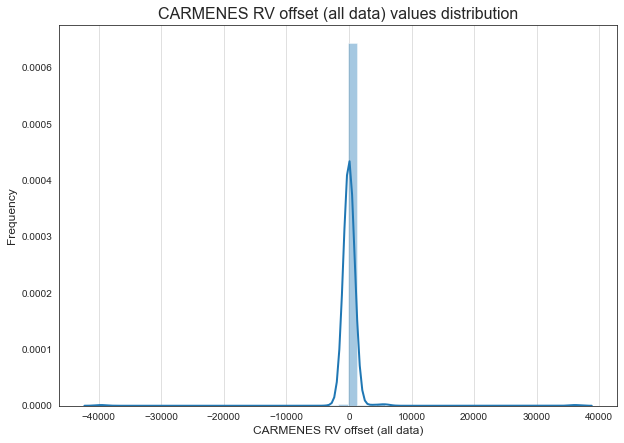

In [32]:
draw_hist(d1=rv_offsets, d1_label="CARMENES RV offset (all data)")

We try to fit the distribution with `distfit`.

[distfit] >fit..
[distfit] >transform..
[distfit] >[norm      ] [0.00 sec] [RSS: 0.0000003] [loc=32.016 scale=2887.505]
[distfit] >[expon     ] [0.00 sec] [RSS: 0.0000004] [loc=-39609.825 scale=39641.841]
[distfit] >[pareto    ] [0.02 sec] [RSS: 0.0000004] [loc=-39611.620 scale=1.795]
[distfit] >[dweibull  ] [0.02 sec] [RSS: 0.0000003] [loc=-5.530 scale=1206.193]
[distfit] >[t         ] [0.02 sec] [RSS: 0.0000004] [loc=-5.044 scale=5.426]
[distfit] >[genextreme] [0.15 sec] [RSS: 0.0000004] [loc=1456.730 scale=0.889]
[distfit] >[gamma     ] [0.05 sec] [RSS: 0.0000004] [loc=-580.593 scale=4.398]
[distfit] >[lognorm   ] [0.09 sec] [RSS: 0.0000004] [loc=-39609.825 scale=5.311]
[distfit] >[beta      ] [0.06 sec] [RSS: 0.0000003] [loc=-1354786.688 scale=1688631.200]
[distfit] >[uniform   ] [0.00 sec] [RSS: 0.0000004] [loc=-39609.825 scale=75732.348]
[distfit] >[loggamma  ] [0.02 sec] [RSS: 0.0000001] [loc=-4483.914 scale=2516.258]
[distfit] >Compute confidence interval [parametric]
[distfit]

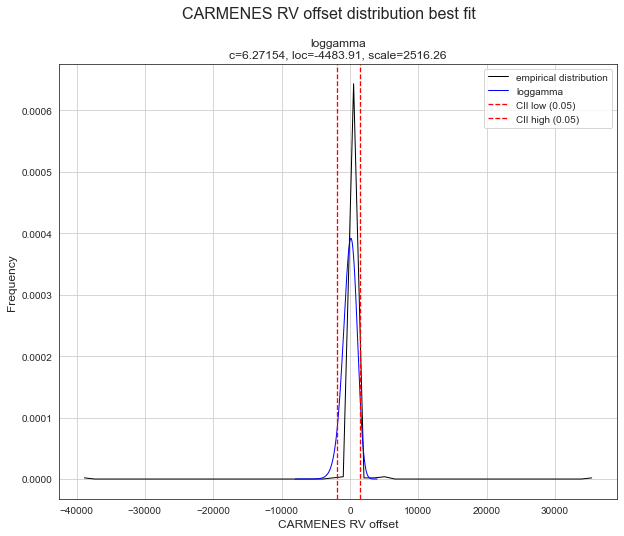

In [33]:
# Initialize the model:
dist = distfit()
# Fit the data:
dist.fit_transform(pd.Series(rv_offsets))
# Plot results:
dist.plot()
plt.suptitle("CARMENES RV offset distribution best fit", fontsize=16)
plt.xlabel("CARMENES RV offset", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.show();

In [34]:
# Generate a new sample:
repro_offsets = dist.generate(n=len(rv_offsets), random_state=RANDOM_STATE)

[distfit] >Generate 355 loggamma distributed samples with fitted params (6.271542848163972, -4483.9142271669825, 2516.2583826503533).


In [35]:
dist.model['name']

'loggamma'

stat=0.282, p=0.778
Probably the same distribution


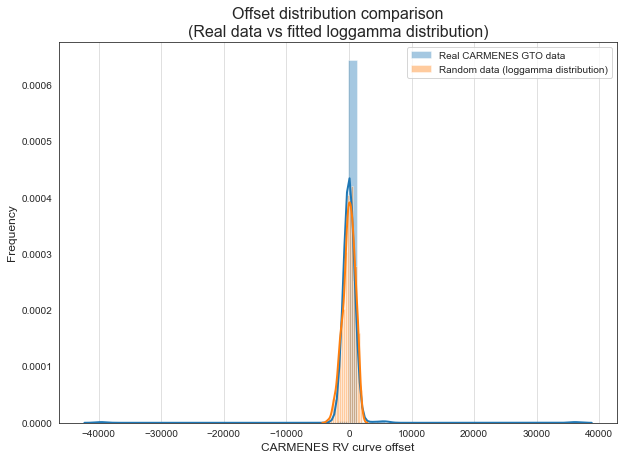

In [36]:
# Compare real and random sample:
compare_dist(rv_offsets, repro_offsets,"Real CARMENES GTO data", "Random data (%s distribution)" %dist.model['name'],
             fig_title="Offset distribution comparison\n(Real data vs fitted %s distribution)" %dist.model['name'],
             varname="CARMENES RV curve offset",
             fig_filename=IMAGE_FOLDER + "SyntheticDataset_07_01_CARMENES_RV_Offset_distfit.png")


We try to discard the outliers outside a given number of standard deviations $\sigma$.

In [37]:
rv_offsets_sigma = discard_outliers_sigma(x=rv_offsets, n_sigmas=SIGMAS)

In [38]:
len(rv_offsets_sigma)

353

count     353.000000
mean       42.076424
std       493.832290
min     -2324.962966
25%       -10.903228
50%        -4.562068
75%         1.706854
max      5716.480814
dtype: float64
p = 3.84676e-126
***This distribution does NOT come from a Gaussian distribution(with significance level = 0.999000)


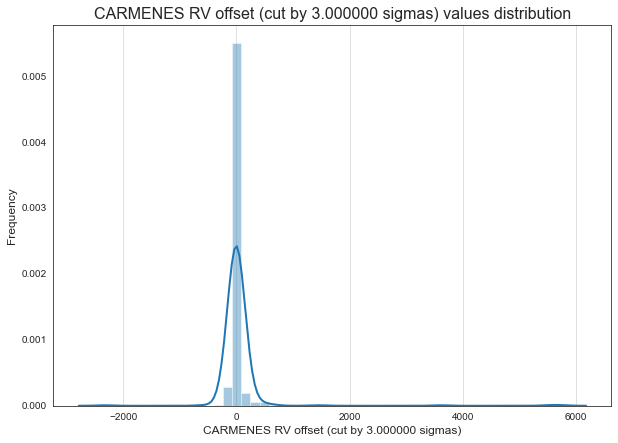

In [39]:
draw_hist(d1=rv_offsets_sigma, d1_label="CARMENES RV offset (cut by %f sigmas)" %SIGMAS)

[distfit] >fit..
[distfit] >transform..
[distfit] >[norm      ] [0.00 sec] [RSS: 0.0000241] [loc=42.076 scale=493.132]
[distfit] >[expon     ] [0.0 sec] [RSS: 0.0000297] [loc=-2324.963 scale=2367.039]
[distfit] >[pareto    ] [0.02 sec] [RSS: 0.0000312] [loc=-2327.060 scale=2.097]
[distfit] >[dweibull  ] [0.03 sec] [RSS: 0.0000014] [loc=-4.020 scale=31.835]
[distfit] >[t         ] [0.02 sec] [RSS: 0.0000139] [loc=-5.061 scale=5.544]
[distfit] >[genextreme] [0.06 sec] [RSS: 0.0000307] [loc=-2322.597 scale=12.440]
[distfit] >[gamma     ] [0.05 sec] [RSS: 0.0000303] [loc=-580.593 scale=4.723]
[distfit] >[lognorm   ] [0.06 sec] [RSS: 0.0000220] [loc=-3655.291 scale=3676.239]
[distfit] >[beta      ] [0.07 sec] [RSS: 0.0000233] [loc=-2838.823 scale=62654578.065]
[distfit] >[uniform   ] [0.0 sec] [RSS: 0.0000296] [loc=-2324.963 scale=8041.444]
[distfit] >[loggamma  ] [0.04 sec] [RSS: 0.0000246] [loc=-154937.974 scale=21096.318]
[distfit] >Compute confidence interval [parametric]
[distfit] >plo

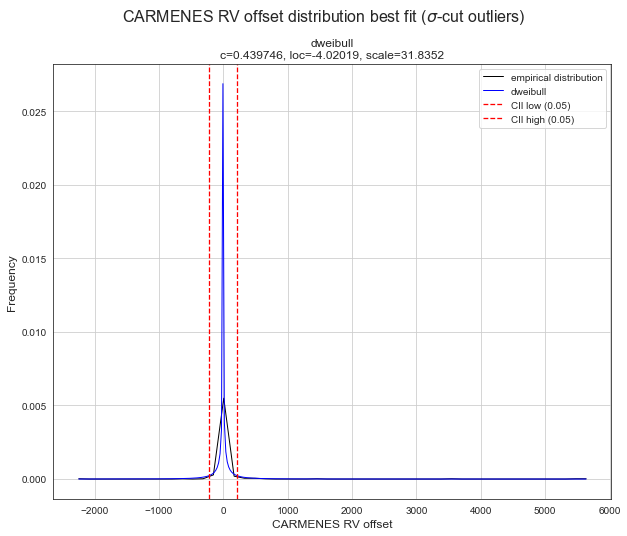

In [40]:
# Initialize the model:
dist = distfit()
# Fit the data:
dist.fit_transform(pd.Series(rv_offsets_sigma))
# Plot results:
dist.plot()
plt.suptitle("CARMENES RV offset distribution best fit ($\sigma$-cut outliers)", fontsize=16)
plt.xlabel("CARMENES RV offset", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.show();

In [41]:
# Generate a new sample:
repro_offsets_sigma = dist.generate(n=len(rv_offsets_sigma), random_state=RANDOM_STATE)

[distfit] >Generate 353 dweibull distributed samples with fitted params (0.43974580147830894, -4.020188477467666, 31.8352129895934).


stat=1.081, p=0.280
Probably the same distribution


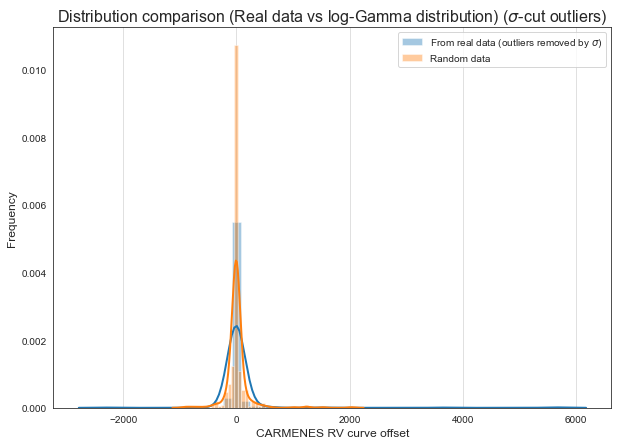

In [42]:
# Compare real and random sample:
compare_dist(rv_offsets_sigma, repro_offsets_sigma,
             "From real data (outliers removed by $\sigma$)",
             "Random data",
             fig_title="Distribution comparison (Real data vs log-Gamma distribution) ($\sigma$-cut outliers)",
             varname="CARMENES RV curve offset",
             fig_filename=None)

We now discard outliers by percentiles:

In [43]:
rv_offsets_pc = discard_outliers_pc(x=rv_offsets, low_pc=LOW_PC, high_pc=HIGH_PC)

In [44]:
len(rv_offsets_pc)

347

count     347.000000
mean        9.089896
std       110.286793
min      -212.510294
25%       -10.862726
50%        -4.562068
75%         1.583342
max      1457.403600
dtype: float64
p = 5.13206e-116
***This distribution does NOT come from a Gaussian distribution(with significance level = 0.999000)


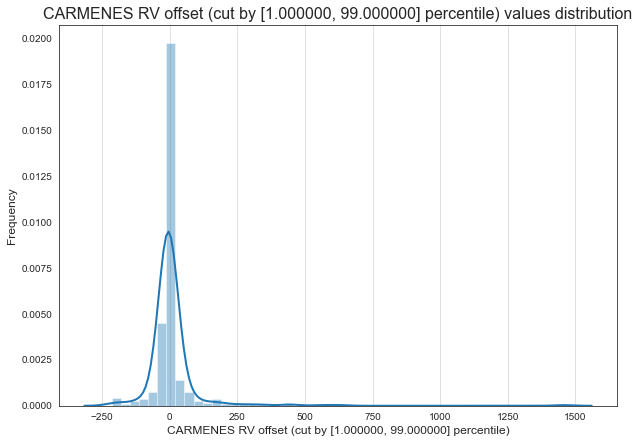

In [45]:
draw_hist(d1=rv_offsets_pc, d1_label="CARMENES RV offset (cut by [%f, %f] percentile)" %(LOW_PC, HIGH_PC))

[distfit] >fit..
[distfit] >transform..
[distfit] >[norm      ] [0.00 sec] [RSS: 0.0002920] [loc=9.090 scale=110.128]
[distfit] >[expon     ] [0.0 sec] [RSS: 0.0003778] [loc=-212.510 scale=221.600]
[distfit] >[pareto    ] [0.05 sec] [RSS: 0.0003834] [loc=-238201386.115 scale=238201173.604]
[distfit] >[dweibull  ] [0.03 sec] [RSS: 0.0000743] [loc=-4.054 scale=16.830]
[distfit] >[t         ] [0.02 sec] [RSS: 0.0000424] [loc=-5.087 scale=5.719]
[distfit] >[genextreme] [0.13 sec] [RSS: 0.0003582] [loc=-182.233 scale=168.927]
[distfit] >[gamma     ] [0.04 sec] [RSS: 0.0002512] [loc=-256.921 scale=23.743]
[distfit] >[lognorm   ] [0.05 sec] [RSS: 0.0004154] [loc=-212.510 scale=0.415]
[distfit] >[beta      ] [0.06 sec] [RSS: 0.0002521] [loc=-255.318 scale=346938880634381.750]
[distfit] >[uniform   ] [0.0 sec] [RSS: 0.0003964] [loc=-212.510 scale=1669.914]
[distfit] >[loggamma  ] [0.04 sec] [RSS: 0.0003022] [loc=-82620.985 scale=9491.258]
[distfit] >Compute confidence interval [parametric]
[dis

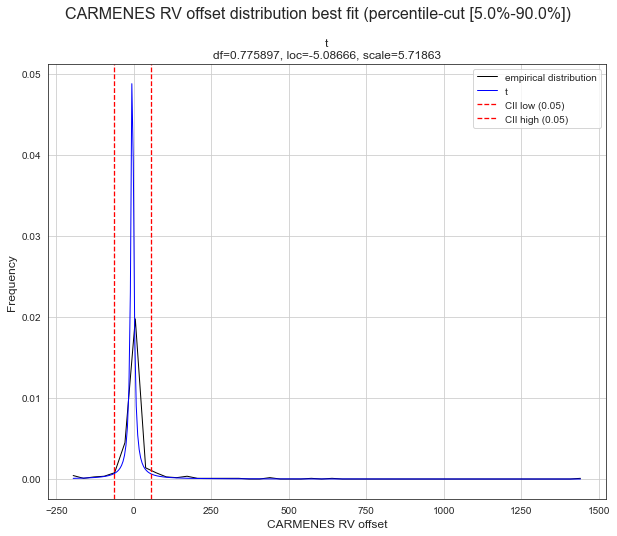

In [46]:
# Initialize the model:
dist = distfit()
# Fit the data:
dist.fit_transform(pd.Series(rv_offsets_pc))
# Plot results:
dist.plot()
plt.suptitle("CARMENES RV offset distribution best fit (percentile-cut [5.0%-90.0%])", fontsize=16)
plt.xlabel("CARMENES RV offset", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.show();

In [47]:
# Generate a new sample:
repro_offsets_pc = dist.generate(n=len(rv_offsets_pc), random_state=RANDOM_STATE)

[distfit] >Generate 347 t distributed samples with fitted params (0.7758968567292721, -5.0866641409044835, 5.7186286942406).


stat=1.627, p=0.104
Probably the same distribution


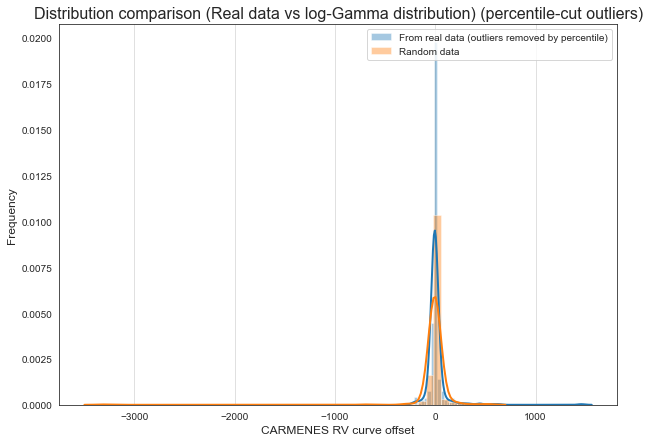

In [48]:
# Compare real and random sample:
compare_dist(rv_offsets_pc, repro_offsets_pc,
             "From real data (outliers removed by percentile)",
             "Random data",
             fig_title="Distribution comparison (Real data vs log-Gamma distribution) (percentile-cut outliers)",
             varname="CARMENES RV curve offset",
             fig_filename=None)

**NOTE:** Normal distribution also seemed to fit reasonably into the data, so we try it:

[distfit] >fit..
[distfit] >transform..
[distfit] >[norm] [0.00 sec] [RSS: 0.0000003] [loc=32.016 scale=2887.505]
[distfit] >Compute confidence interval [parametric]
[distfit] >plot..


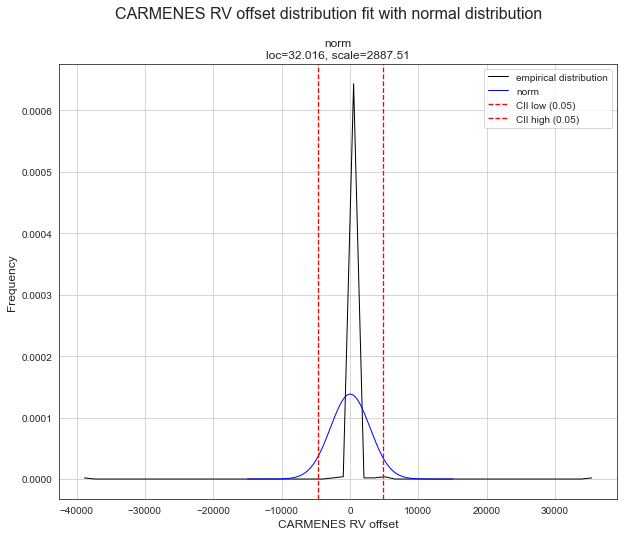

In [49]:
# Initialize the model:
dist = distfit(distr='norm')
# Fit the data:
dist.fit_transform(pd.Series(rv_offsets))
# Plot results:
dist.plot()
plt.suptitle("CARMENES RV offset distribution fit with normal distribution", fontsize=16)
plt.xlabel("CARMENES RV offset", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.show();

In [50]:
# Generate a new sample:
repro_offsets = dist.generate(n=len(rv_offsets), random_state=RANDOM_STATE)

[distfit] >Generate 355 norm distributed samples with fitted params (32.015989406807016, 2887.5050720650465).


stat=0.241, p=0.809
Probably the same distribution


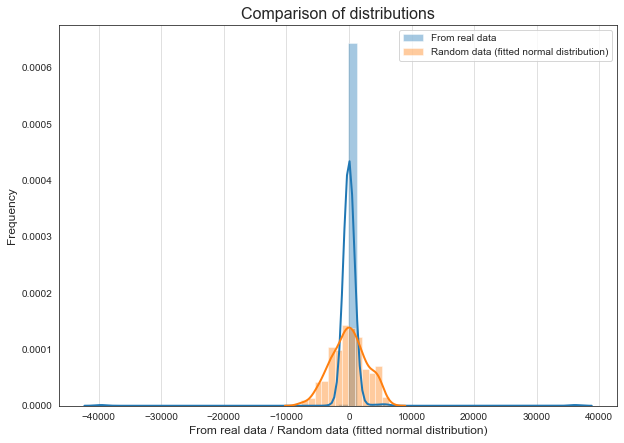

In [51]:
# Compare real and random sample:
compare_dist(rv_offsets, repro_offsets,
             "From real data", "Random data (fitted normal distribution)", fig_filename=None)

Does not seem a good fit, the generated data are much more spread over the axis. Besides, the score of the fitting is worst that the one we got for the log-Gamma distribution.

**CONCLUSION:** The log-gamma distribution seems to be the most appropriate. In fact, removing the outliers does not produce a better score of the distributions fits. Moreover, if we want to reproduce the characteristics of the real data, we must keep the outliers, as they are also part of the real dataset.

Hence, we do repeat the original fitting.

In [52]:
# Initialize the model:
dist = distfit()
# Fit the data:
dist.fit_transform(pd.Series(rv_offsets))
dist.model

[distfit] >fit..
[distfit] >transform..
[distfit] >[norm      ] [0.00 sec] [RSS: 0.0000003] [loc=32.016 scale=2887.505]
[distfit] >[expon     ] [0.0 sec] [RSS: 0.0000004] [loc=-39609.825 scale=39641.841]
[distfit] >[pareto    ] [0.02 sec] [RSS: 0.0000004] [loc=-39611.620 scale=1.795]
[distfit] >[dweibull  ] [0.02 sec] [RSS: 0.0000003] [loc=-5.530 scale=1206.193]
[distfit] >[t         ] [0.02 sec] [RSS: 0.0000004] [loc=-5.044 scale=5.426]
[distfit] >[genextreme] [0.14 sec] [RSS: 0.0000004] [loc=1456.730 scale=0.889]
[distfit] >[gamma     ] [0.06 sec] [RSS: 0.0000004] [loc=-580.593 scale=4.398]
[distfit] >[lognorm   ] [0.08 sec] [RSS: 0.0000004] [loc=-39609.825 scale=5.311]
[distfit] >[beta      ] [0.06 sec] [RSS: 0.0000003] [loc=-1354786.688 scale=1688631.200]
[distfit] >[uniform   ] [0.0 sec] [RSS: 0.0000004] [loc=-39609.825 scale=75732.348]
[distfit] >[loggamma  ] [0.02 sec] [RSS: 0.0000001] [loc=-4483.914 scale=2516.258]
[distfit] >Compute confidence interval [parametric]


{'distr': <scipy.stats._continuous_distns.loggamma_gen at 0x1e231913940>,
 'stats': 'RSS',
 'params': (6.271542848163972, -4483.9142271669825, 2516.2583826503533),
 'name': 'loggamma',
 'model': <scipy.stats._distn_infrastructure.rv_frozen at 0x1e237638730>,
 'score': 1.320590007584484e-07,
 'loc': -4483.9142271669825,
 'scale': 2516.2583826503533,
 'arg': (6.271542848163972,),
 'CII_min_alpha': -1899.4527915696203,
 'CII_max_alpha': 1521.439616075064}

In [53]:
group = "BENCHMARK"
variable = "offsetRV"
dist_to_save = distfit(distr='loggamma')
dist_to_save.fit_transform(pd.Series(rv_offsets))
d_model = dist_to_save.model
filename = group + "_" + variable +"_All_GTO_dist.pickle"
fit_dist = fit_dist.append({'Group': group,
                            'Variable': variable,
                            'Distribution': d_model,
                            'Dist_file': filename}, ignore_index=True)
if filename is None:
    pass
else:
    dist_to_save.save(DIST_FILES_FOLDER + filename)
fit_dist.to_csv(DIST_SUMMARY_FILE, sep=',', decimal='.', index=False)

[distfit] >fit..
[distfit] >transform..
[distfit] >[loggamma] [0.02 sec] [RSS: 0.0000001] [loc=-4483.914 scale=2516.258]
[distfit] >Compute confidence interval [parametric]
[pypickle] Pickle file saved: [./DIST_FILES/BENCHMARK_offsetRV_All_GTO_dist.pickle]
[distfit] >Saving.. True


In [54]:
fit_dist

,Group,Variable,Distribution,Dist_file
0,BENCHMARK,Ps,{'fixed_value': 0.0025},None
1,BENCHMARK,Tobs,{'fixed_value': 0.25},None
2,BENCHMARK,frequency,{'distr': <scipy.stats._continuous_distns.unif...,BENCHMARK_frequency_All_GTO_dist.pickle
3,BENCHMARK,phase,{'distr': <scipy.stats._continuous_distns.unif...,BENCHMARK_phase_All_GTO_dist.pickle
4,BENCHMARK,amplitudeRV,{'distr': <scipy.stats._continuous_distns.unif...,BENCHMARK_amplitudeRV_All_GTO_dist.pickle
5,BENCHMARK,offsetRV,{'distr': <scipy.stats._continuous_distns.logg...,BENCHMARK_offsetRV_All_GTO_dist.pickle


#### CARMENES reference epoch (from real data)

Having seen the result in the previous section, we will go for the best fit distribution for all the data.

count    3.550000e+02
mean     2.457677e+06
std      4.898903e+02
min      2.457392e+06
25%      2.457420e+06
50%      2.457494e+06
75%      2.457628e+06
max      2.459491e+06
dtype: float64
p = 7.0622e-42
***This distribution does NOT come from a Gaussian distribution(with significance level = 0.999000)


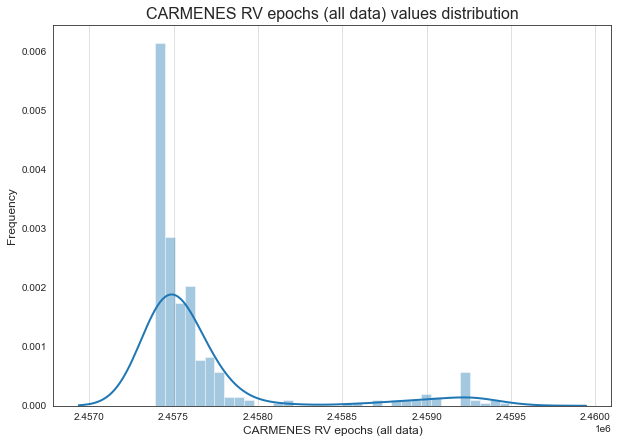

In [55]:
draw_hist(d1=rv_epochs, d1_label="CARMENES RV epochs (all data)")

We try to fit the distribution with `distfit`.

[distfit] >fit..
[distfit] >transform..
[distfit] >[norm      ] [0.00 sec] [RSS: 0.0000588] [loc=2457676.643 scale=489.200]
[distfit] >[expon     ] [0.00 sec] [RSS: 0.0000191] [loc=2457392.300 scale=284.343]
[distfit] >[pareto    ] [0.05 sec] [RSS: 0.0000191] [loc=-19.568 scale=2457411.868]
[distfit] >[dweibull  ] [0.02 sec] [RSS: 0.0000424] [loc=2457474.662 scale=393.571]
[distfit] >[t         ] [0.04 sec] [RSS: 0.0000597] [loc=2457708.214 scale=487.515]
[distfit] >[genextreme] [0.11 sec] [RSS: 0.0000079] [loc=2457433.811 scale=66.358]
[distfit] >[gamma     ] [0.02 sec] [RSS: 0.0000090] [loc=2457392.300 scale=600.492]
[distfit] >[lognorm   ] [0.04 sec] [RSS: 0.0000046] [loc=2457392.088 scale=81.403]
[distfit] >[beta      ] [0.07 sec] [RSS: 0.0000444] [loc=2457392.300 scale=2098.381]
[distfit] >[uniform   ] [0.0 sec] [RSS: 0.0000689] [loc=2457392.300 scale=2098.381]
[distfit] >[loggamma  ] [0.04 sec] [RSS: 0.0000596] [loc=2311075.644 scale=20043.399]
[distfit] >Compute confidence inter

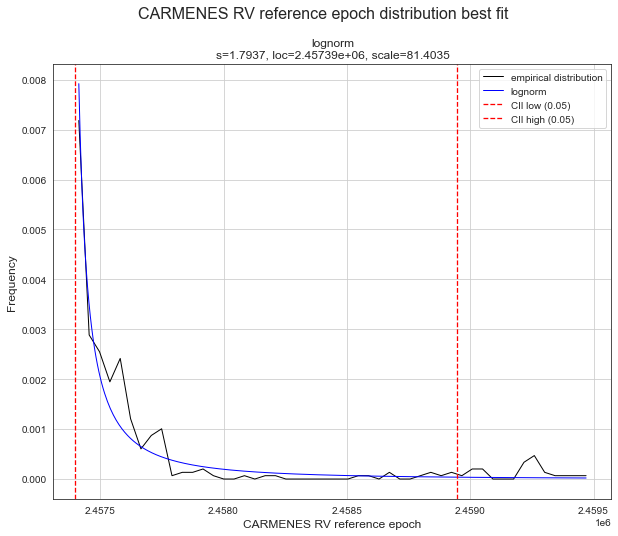

In [56]:
# Initialize the model:
dist = distfit()
# Fit the data:
dist.fit_transform(pd.Series(rv_epochs))
# Plot results:
dist.plot()
plt.suptitle("CARMENES RV reference epoch distribution best fit", fontsize=16)
plt.xlabel("CARMENES RV reference epoch", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.show();

In [57]:
# Generate a new sample:
repro_epochs = dist.generate(n=len(rv_epochs), random_state=RANDOM_STATE)

[distfit] >Generate 355 lognorm distributed samples with fitted params (1.7937046895625994, 2457392.087539447, 81.40346272109937).


stat=-0.233, p=0.816
Probably the same distribution


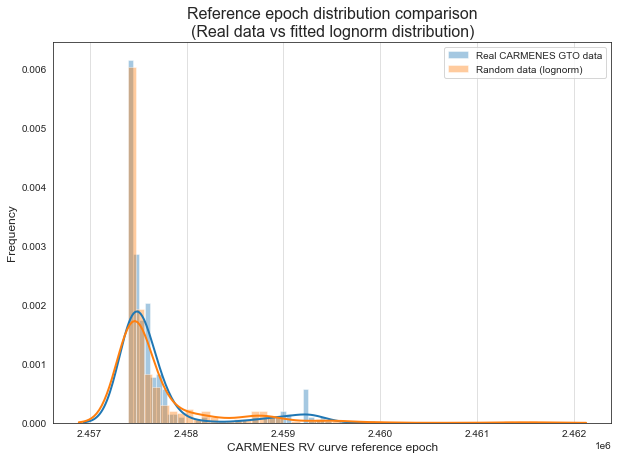

In [58]:
# Compare real and random sample:
compare_dist(rv_epochs, repro_epochs,
             "Real CARMENES GTO data", "Random data (%s)" %dist.model['name'],
             fig_title="Reference epoch distribution comparison\n(Real data vs fitted %s distribution)" %dist.model['name'],
             varname="CARMENES RV curve reference epoch",
             fig_filename=IMAGE_FOLDER + "SyntheticDataset_07_02_CARMENES_RV_RefEpoch_distfit.png")


**CONCLUSION:** this log-normal distribution is very fine.

In [59]:
dist.model

{'distr': <scipy.stats._continuous_distns.lognorm_gen at 0x1e231913eb0>,
 'stats': 'RSS',
 'params': (1.7937046895625994, 2457392.087539447, 81.40346272109937),
 'name': 'lognorm',
 'model': <scipy.stats._distn_infrastructure.rv_frozen at 0x1e237cfd160>,
 'score': 4.568588041917488e-06,
 'loc': 2457392.087539447,
 'scale': 81.40346272109937,
 'arg': (1.7937046895625994,),
 'CII_min_alpha': 2457396.3465469275,
 'CII_max_alpha': 2458947.9720437885}

In [60]:
group = "BENCHMARK"
variable = "refepochRV"
d_model = dist.model
filename = group + "_" + variable +"_All_GTO_dist.pickle"
fit_dist = fit_dist.append({'Group': group,
                            'Variable': variable,
                            'Distribution': d_model,
                            'Dist_file': filename}, ignore_index=True)
if filename is None:
    pass
else:
    dist.save(DIST_FILES_FOLDER + filename)
fit_dist.to_csv(DIST_SUMMARY_FILE, sep=',', decimal='.', index=False)

[pypickle] Pickle file saved: [./DIST_FILES/BENCHMARK_refepochRV_All_GTO_dist.pickle]
[distfit] >Saving.. True


In [61]:
fit_dist

,Group,Variable,Distribution,Dist_file
0,BENCHMARK,Ps,{'fixed_value': 0.0025},None
1,BENCHMARK,Tobs,{'fixed_value': 0.25},None
2,BENCHMARK,frequency,{'distr': <scipy.stats._continuous_distns.unif...,BENCHMARK_frequency_All_GTO_dist.pickle
3,BENCHMARK,phase,{'distr': <scipy.stats._continuous_distns.unif...,BENCHMARK_phase_All_GTO_dist.pickle
4,BENCHMARK,amplitudeRV,{'distr': <scipy.stats._continuous_distns.unif...,BENCHMARK_amplitudeRV_All_GTO_dist.pickle
5,BENCHMARK,offsetRV,{'distr': <scipy.stats._continuous_distns.logg...,BENCHMARK_offsetRV_All_GTO_dist.pickle
6,BENCHMARK,refepochRV,{'distr': <scipy.stats._continuous_distns.logn...,BENCHMARK_refepochRV_All_GTO_dist.pickle


#### CARMENES noise (from real data)

count    18363.000000
mean         7.453507
std         79.016692
min          0.421764
25%          1.002802
50%          1.310013
75%          2.012329
max       3563.760616
dtype: float64
p = 0
***This distribution does NOT come from a Gaussian distribution(with significance level = 0.999000)


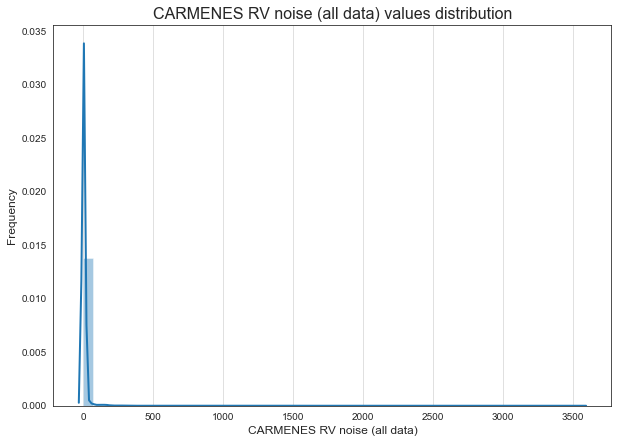

In [62]:
draw_hist(d1=rv_rms, d1_label="CARMENES RV noise (all data)")

We try to fit the distribution with `distfit`.

[distfit] >fit..
[distfit] >transform..
[distfit] >[norm      ] [0.00 sec] [RSS: 0.0000877] [loc=7.454 scale=79.015]
[distfit] >[expon     ] [0.0 sec] [RSS: 0.0001673] [loc=0.422 scale=7.032]
[distfit] >[pareto    ] [0.23 sec] [RSS: 0.0001835] [loc=-1.665 scale=2.087]
[distfit] >[dweibull  ] [0.33 sec] [RSS: 0.0001854] [loc=1.103 scale=0.987]
[distfit] >[t         ] [0.07 sec] [RSS: 0.0001866] [loc=1.176 scale=0.312]
[distfit] >[genextreme] [0.23 sec] [RSS: 0.0001770] [loc=1.200 scale=0.751]
[distfit] >[gamma     ] [0.20 sec] [RSS: 0.0001913] [loc=0.422 scale=2.911]
[distfit] >[lognorm   ] [0.20 sec] [RSS: 0.0001884] [loc=0.421 scale=1.140]
[distfit] >[beta      ] [0.40 sec] [RSS: 0.0001857] [loc=0.422 scale=6555.319]
[distfit] >[uniform   ] [0.0 sec] [RSS: 0.0001873] [loc=0.422 scale=3563.339]
[distfit] >[loggamma  ] [0.27 sec] [RSS: 0.0001160] [loc=-6797.125 scale=1374.192]
[distfit] >Compute confidence interval [parametric]
[distfit] >plot..


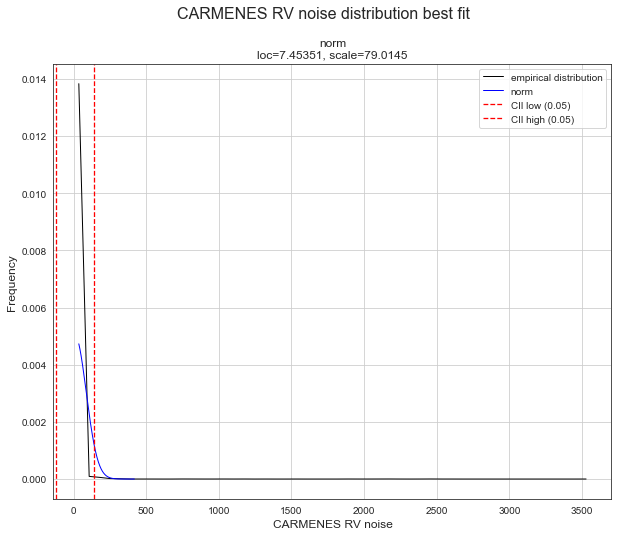

In [63]:
# Initialize the model:
dist = distfit()
# Fit the data:
dist.fit_transform(pd.Series(rv_rms))
# Plot results:
dist.plot()
plt.suptitle("CARMENES RV noise distribution best fit", fontsize=16)
plt.xlabel("CARMENES RV noise", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.show();

In [64]:
# Generate a new sample:
repro_rms = dist.generate(n=len(rv_rms), random_state=RANDOM_STATE)

[distfit] >Generate 18363 norm distributed samples with fitted params (7.453506944937184, 79.01454046011588).


stat=-0.644, p=0.520
Probably the same distribution


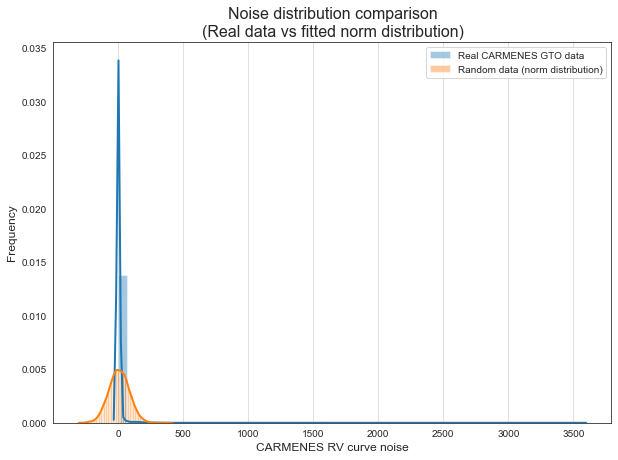

In [66]:
# Compare real and random sample:
compare_dist(rv_rms, repro_rms,
             "Real CARMENES GTO data", "Random data (%s distribution)" %dist.model['name'],
             fig_title="Noise distribution comparison\n(Real data vs fitted %s distribution)" %dist.model['name'],
             varname="CARMENES RV curve noise",
             fig_filename=IMAGE_FOLDER + "SyntheticDataset_07_02B_CARMENES_RV_Noise_INITIAL_distfit.png")


**OBSERVATION:** It seems that here we need to remove outliers, because real and random distributions seem pretty different from each other, and the score value of the fitting is relatively high.

In [67]:
rv_rms_sigma = discard_outliers_sigma(x=rv_rms, n_sigmas=SIGMAS)

In [68]:
len(rv_rms)

18363

In [69]:
len(rv_rms_sigma)

18305

[distfit] >fit..
[distfit] >transform..
[distfit] >[norm      ] [0.00 sec] [RSS: 0.0278526] [loc=4.106 scale=15.515]
[distfit] >[expon     ] [0.00 sec] [RSS: 0.0033215] [loc=0.422 scale=3.684]
[distfit] >[pareto    ] [0.20 sec] [RSS: 0.0102265] [loc=-0.829 scale=1.250]
[distfit] >[dweibull  ] [0.24 sec] [RSS: 0.0193530] [loc=1.108 scale=0.930]
[distfit] >[t         ] [0.05 sec] [RSS: 0.0227157] [loc=1.179 scale=0.316]
[distfit] >[genextreme] [0.31 sec] [RSS: 0.0093728] [loc=1.148 scale=0.555]
[distfit] >[gamma     ] [0.19 sec] [RSS: 0.0305443] [loc=0.422 scale=8.596]
[distfit] >[lognorm   ] [0.13 sec] [RSS: 0.0050599] [loc=0.421 scale=1.117]
[distfit] >[beta      ] [0.40 sec] [RSS: 0.0016897] [loc=0.422 scale=1178.069]
[distfit] >[uniform   ] [0.0 sec] [RSS: 0.0348862] [loc=0.422 scale=242.158]
[distfit] >[loggamma  ] [0.25 sec] [RSS: 0.0283692] [loc=-5182.069 scale=694.350]
[distfit] >Compute confidence interval [parametric]
[distfit] >plot..


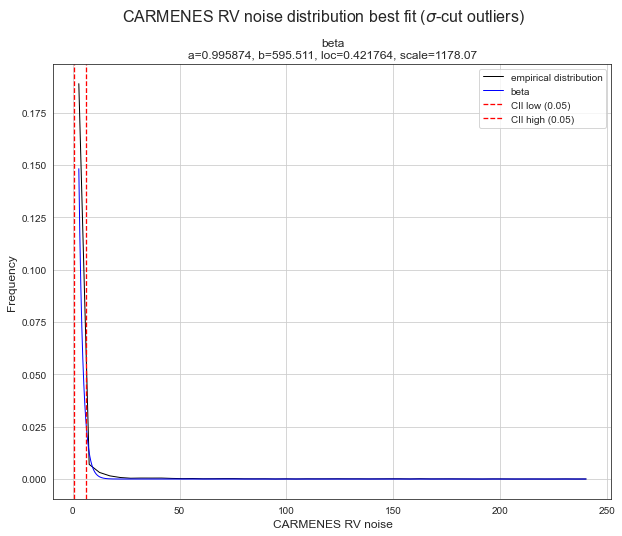

In [70]:
# Initialize the model:
dist = distfit()
# Fit the data:
dist.fit_transform(pd.Series(rv_rms_sigma))
# Plot results:
dist.plot()
plt.suptitle("CARMENES RV noise distribution best fit ($\sigma$-cut outliers)", fontsize=16)
plt.xlabel("CARMENES RV noise", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.show();

In [71]:
# Generate a new sample:
repro_rms_sigma = dist.generate(n=len(rv_rms_sigma), random_state=RANDOM_STATE)

[distfit] >Generate 18305 beta distributed samples with fitted params (0.9958736128535881, 595.5110675980816, 0.42176414000699997, 1178.0692831417368).


stat=14.798, p=0.000
***Probably different distributions


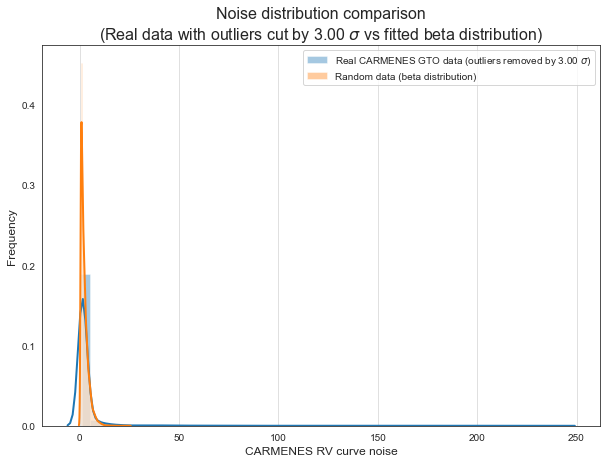

In [72]:
# Compare real and random sample:
compare_dist(rv_rms_sigma, repro_rms_sigma,
             "Real CARMENES GTO data (outliers removed by %.2f $\sigma$)" %SIGMAS,
             "Random data (%s distribution)" %dist.model['name'],
             fig_title="Noise distribution comparison\n(Real data with outliers cut by %.2f $\sigma$ " \
                 "vs fitted %s distribution)" %(SIGMAS, dist.model['name']),
             varname="CARMENES RV curve noise",
             fig_filename=IMAGE_FOLDER + "SyntheticDataset_07_03_CARMENES_RV_Noise_distfit.png")


**CONCLUSSION:** this $\beta$ distribution seems more logical (even when the score value is higher than the previous fit), and more appropriate for a noise distribution, because in our real dataset all error values are stated as positive values.

In [73]:
group = "RV"
variable = "noiseRV"
d_model = dist.model
filename = group + "_" + variable +"_All_GTO_dist.pickle"
fit_dist = fit_dist.append({'Group': group,
                            'Variable': variable,
                            'Distribution': d_model,
                            'Dist_file': filename}, ignore_index=True)
if filename is None:
    pass
else:
    dist.save(DIST_FILES_FOLDER + filename)
fit_dist.to_csv(DIST_SUMMARY_FILE, sep=',', decimal='.', index=False)

[pypickle] Pickle file saved: [./DIST_FILES/RV_noiseRV_All_GTO_dist.pickle]
[distfit] >Saving.. True


In [74]:
fit_dist

,Group,Variable,Distribution,Dist_file
0,BENCHMARK,Ps,{'fixed_value': 0.0025},None
1,BENCHMARK,Tobs,{'fixed_value': 0.25},None
2,BENCHMARK,frequency,{'distr': <scipy.stats._continuous_distns.unif...,BENCHMARK_frequency_All_GTO_dist.pickle
3,BENCHMARK,phase,{'distr': <scipy.stats._continuous_distns.unif...,BENCHMARK_phase_All_GTO_dist.pickle
4,BENCHMARK,amplitudeRV,{'distr': <scipy.stats._continuous_distns.unif...,BENCHMARK_amplitudeRV_All_GTO_dist.pickle
5,BENCHMARK,offsetRV,{'distr': <scipy.stats._continuous_distns.logg...,BENCHMARK_offsetRV_All_GTO_dist.pickle
6,BENCHMARK,refepochRV,{'distr': <scipy.stats._continuous_distns.logn...,BENCHMARK_refepochRV_All_GTO_dist.pickle
7,RV,noiseRV,{'distr': <scipy.stats._continuous_distns.beta...,RV_noiseRV_All_GTO_dist.pickle


**IMPORTANT NOTE:** Some last checks must be made, though. Have the RMS of **each** individual curve different distributions? Is RMS dependant on other parameters of the curve (mean signal value, maximum signal range)?

We first check the relation between average RMS and mean signal value:

No handles with labels found to put in legend.


Pearson's correlation value: 0.118


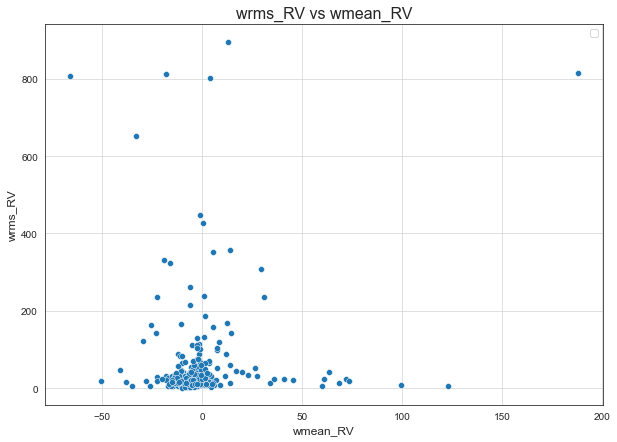

In [75]:
scatter_graph(gto[(gto['wrms_RV'] >= -1000.0) & (gto['wrms_RV'] <= 1000.0)],
              'wmean_RV', 'wrms_RV', fig_filename=None)

**OBSERVATION:** it does not seem to be a clear relationship. Pearson's coefficfient is also small.

We now check the relation between average RMS and maximum signal amplitude (difference maximum minus minimum signal value). First we need to calculate this range.

In [76]:
gto['signal_range_RV'] = None
for i in range(0, len(gto)):
    rv_file = gto.loc[i, 'rv_file']
    rv = pd.read_csv(rv_file, sep=' ', decimal='.',
                     names=['time', 'rv', 'rv_error'])
    signal_range = rv['rv'].max() - rv['rv'].min()
    gto.loc[i, 'signal_range_RV'] = signal_range
gto.head()  

,index,Karmn,Name,Comp,GJ,RA_J2016_deg,DE_J2016_deg,RA_J2000,DE_J2000,l_J2016_deg,...,e_T0_PG_TESS,offset_PG_TESS,e_offset_PG_TESS,FAP_PG_TESS,valid_PG_TESS,error_PG_TESS,elapsed_time_PG_TESS,fits_file_TESS,fig_file_TESS,signal_range_RV
0,0,J23585+076,Wolf 1051,AB,4383,359.636420,7.656947,23:58:32.65,+07:39:30.1,100.839686,...,NaN,NaN,NaN,NaN,0.0,Not recognized as a supported data product:\nn...,0.002199,NaN,NaN,5436.200619
1,1,J23556-061,GJ 912,AB,912,358.913617,-6.144283,23:55:39.78,-06:08:33.4,88.129933,...,NaN,NaN,NaN,NaN,0.0,Not recognized as a supported data product:\nn...,0.000974,NaN,NaN,1500.209898
2,2,J23548+385,RX J2354.8+3831,-,NaN,358.713658,38.526340,23:54:51.46,+38:31:36.2,110.941908,...,0.010704,8262.219751,1.365667,1.000000,1.0,NaN,344.002685,../data/CARMENES_GTO_TESS_PGs/J23548+385_TESS_...,../data/CARMENES_GTO_TESS_PGs/figures/J23548+3...,138.426028
3,3,J23505-095,LP 763-012,-,4367,357.634705,-9.560964,23:50:31.64,-09:33:32.7,80.777067,...,0.001261,7767.134654,0.094298,0.064148,1.0,NaN,473.533042,../data/CARMENES_GTO_TESS_PGs/J23505-095_TESS_...,../data/CARMENES_GTO_TESS_PGs/figures/J23505-0...,26.568558
4,4,J23492+024,BR Psc,-,908,357.306604,2.396918,23:49:12.53,+02:24:04.4,93.567467,...,NaN,NaN,NaN,NaN,0.0,Not recognized as a supported data product:\nn...,0.000984,NaN,NaN,33.826318


In [77]:
print(list(gto.columns))

['index', 'Karmn', 'Name', 'Comp', 'GJ', 'RA_J2016_deg', 'DE_J2016_deg', 'RA_J2000', 'DE_J2000', 'l_J2016_deg', 'b_J2016_deg', 'Ref01', 'SpT', 'SpTnum', 'Ref02', 'Teff_K', 'eTeff_K', 'logg', 'elogg', '[Fe/H]', 'e[Fe/H]', 'Ref03', 'L_Lsol', 'eL_Lsol', 'Ref04', 'R_Rsol', 'eR_Rsol', 'Ref05', 'M_Msol', 'eM_Msol', 'Ref06', 'muRA_masa-1', 'emuRA_masa-1', 'muDE_masa-1', 'emuDE_masa-1', 'Ref07', 'pi_mas', 'epi_mas', 'Ref08', 'd_pc', 'ed_pc', 'Ref09', 'Vr_kms-1', 'eVr_kms-1', 'Ref10', 'ruwe', 'Ref11', 'U_kms-1', 'eU_kms-1', 'V_kms-1', 'eV_kms-1', 'W_kms-1', 'eW_kms-1', 'Ref12', 'sa_m/s/a', 'esa_m/s/a', 'Ref13', 'SKG', 'Ref14', 'SKG_lit', 'Ref14_lit', 'Pop', 'Ref15', 'vsini_flag', 'vsini_kms-1', 'evsini_kms-1', 'Ref16', 'P_d', 'eP_d', 'Ref17', 'pEWHalpha_A', 'epEWHalpha_A', 'Ref18', 'log(LHalpha/Lbol)', 'elog(LHalpha/Lbol)', 'Ref19', '1RXS', 'CRT_s-1', 'eCRT_s-1', 'HR1', 'eHR1', 'HR2', 'eHR2', 'Flux_X_E-13_ergcm-2s-1', 'eFlux_X_E-13_ergcm-2s-1', 'LX/LJ', 'eLX/LJ', 'Ref20', 'Activity', 'Ref21', '

No handles with labels found to put in legend.


Pearson's correlation value: 0.501


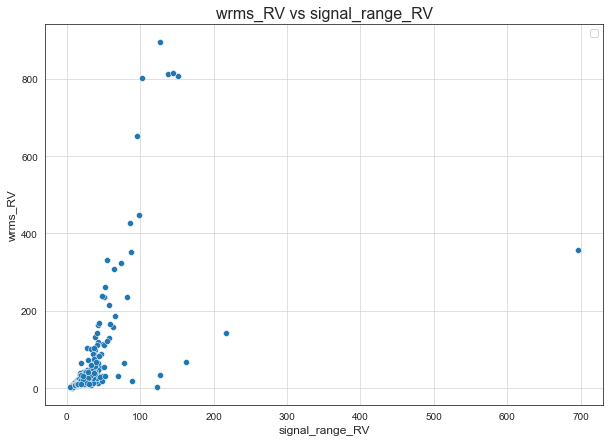

In [78]:
scatter_graph(gto[gto['wrms_RV'] <= 1000.0],
              'signal_range_RV', 'wrms_RV', fig_filename=None)

It seems to show a moderate correlation on 0.501. Let's zoom in the area of WRMS <= 200:

No handles with labels found to put in legend.


Pearson's correlation value: 0.518


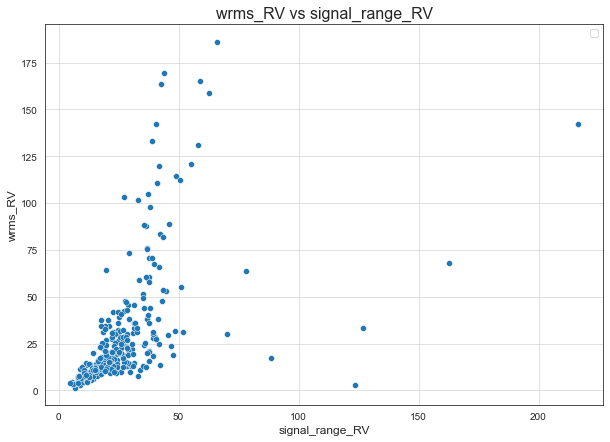

In [79]:
scatter_graph(gto[gto['wrms_RV'] <= 200.0],
              'signal_range_RV', 'wrms_RV', fig_filename=None)

And zoom in to a further RMS < 100:

No handles with labels found to put in legend.


Pearson's correlation value: 0.474


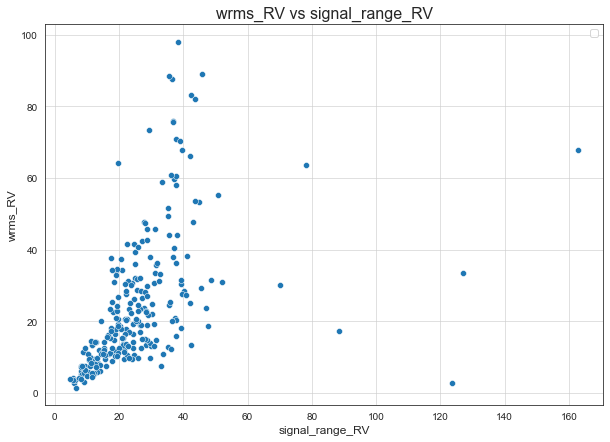

In [80]:
scatter_graph(gto[gto['wrms_RV'] <= 100.0],
              'signal_range_RV', 'wrms_RV', fig_filename=None)

**CONCLUSION:** there is no clear correlation between RMS of the signal and the signal mean value or the signal value ranges, the points are much scattered around.

As a last check, let's record the best distributions for each of the curve errors:

In [81]:
# Initialize:
gto['bestdist_name_RV'] = ""
gto['bestdist_loc_RV'] = None
gto['bestdist_scale_RV'] = None
gto['bestdist_score_RV'] = None
gto['bestdist_error_RV'] = ""
#for i in range(0, 10):
for i in range(0, len(gto)):
    rv_file = gto.loc[i, 'rv_file']
    rv = pd.read_csv(rv_file, sep=' ', decimal='.',
                     names=['time', 'rv', 'rv_error'])
    try:
        dist = distfit()
        # Fit the data:
        dist.fit_transform(rv['rv_error'], verbose=2)
        #print(dist.model)
        gto.loc[i, 'bestdist_name_RV'] = dist.model['name']
        gto.loc[i, 'bestdist_loc_RV'] = dist.model['loc']
        gto.loc[i, 'bestdist_scale_RV'] = dist.model['scale']
        gto.loc[i, 'bestdist_score_RV'] = dist.model['score']
        
    except Exception as e:
        print("Error found at record %d: %s" %(i, str(e)))
        gto.loc[i, 'bestdist_error_RV'] = str(e)
gto.head()

,index,Karmn,Name,Comp,GJ,RA_J2016_deg,DE_J2016_deg,RA_J2000,DE_J2000,l_J2016_deg,...,error_PG_TESS,elapsed_time_PG_TESS,fits_file_TESS,fig_file_TESS,signal_range_RV,bestdist_name_RV,bestdist_loc_RV,bestdist_scale_RV,bestdist_score_RV,bestdist_error_RV
0,0,J23585+076,Wolf 1051,AB,4383,359.636420,7.656947,23:58:32.65,+07:39:30.1,100.839686,...,Not recognized as a supported data product:\nn...,0.002199,NaN,NaN,5436.200619,lognorm,1.27759,1.409538,1.137098,
1,1,J23556-061,GJ 912,AB,912,358.913617,-6.144283,23:55:39.78,-06:08:33.4,88.129933,...,Not recognized as a supported data product:\nn...,0.000974,NaN,NaN,1500.209898,dweibull,1.747472,0.300773,37.678262,
2,2,J23548+385,RX J2354.8+3831,-,NaN,358.713658,38.526340,23:54:51.46,+38:31:36.2,110.941908,...,NaN,344.002685,../data/CARMENES_GTO_TESS_PGs/J23548+385_TESS_...,../data/CARMENES_GTO_TESS_PGs/figures/J23548+3...,138.426028,expon,1.992113,1.052338,19.801631,
3,3,J23505-095,LP 763-012,-,4367,357.634705,-9.560964,23:50:31.64,-09:33:32.7,80.777067,...,NaN,473.533042,../data/CARMENES_GTO_TESS_PGs/J23505-095_TESS_...,../data/CARMENES_GTO_TESS_PGs/figures/J23505-0...,26.568558,genextreme,1.372217,0.308982,2.477701,
4,4,J23492+024,BR Psc,-,908,357.306604,2.396918,23:49:12.53,+02:24:04.4,93.567467,...,Not recognized as a supported data product:\nn...,0.000984,NaN,NaN,33.826318,genextreme,1.048223,0.190965,0.099192,


We can now check the individual distributions:

In [82]:
gto[['bestdist_name_RV', 'Karmn']].groupby(by='bestdist_name_RV').count()

,Karmn
bestdist_name_RV,
beta,43
dweibull,74
expon,11
gamma,22
genextreme,97
lognorm,37
pareto,12
t,58
uniform,1


As we can see, when computed individually, the distributions are pretty different from each other. Let's see the `loc` and `scale` parameters distribution:

count     355.00000
unique    355.00000
top         0.79496
freq        1.00000
Name: bestdist_loc_RV, dtype: float64
p = 3.3317e-173
***This distribution does NOT come from a Gaussian distribution(with significance level = 0.999000)


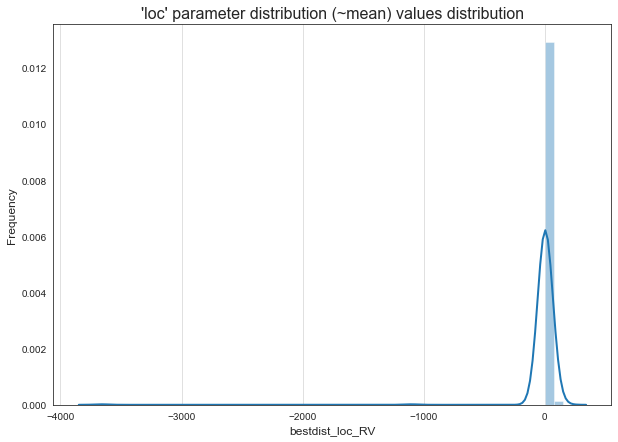

In [83]:
draw_hist(d1=gto['bestdist_loc_RV'], d1_label="'loc' parameter distribution (~mean)")

count     355.000000
unique    355.000000
top         0.808979
freq        1.000000
Name: bestdist_scale_RV, dtype: float64
p = 8.73394e-155
***This distribution does NOT come from a Gaussian distribution(with significance level = 0.999000)


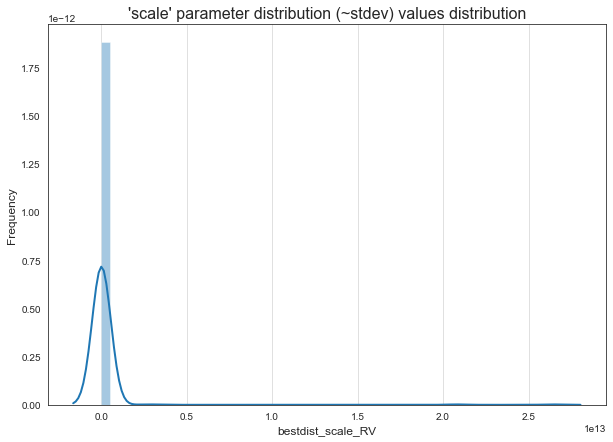

In [84]:
draw_hist(d1=gto['bestdist_scale_RV'], d1_label="'scale' parameter distribution (~stdev)")

**CONCLUSION:** It seems that distributions can be very different from each other. However, we will model the error distribution as a whole over the full real dataset (with the already commented $\beta$ distribution).

#### Sampling spacing for radial velocity curves (based on CARMENES real data)

count    355.000000
mean      15.626037
std       28.637514
min        0.003170
25%        3.504135
50%        8.474980
75%       18.048045
max      307.604870
Name: Ps_RV, dtype: float64
p = 9.20407e-106
***This distribution does NOT come from a Gaussian distribution(with significance level = 0.999000)


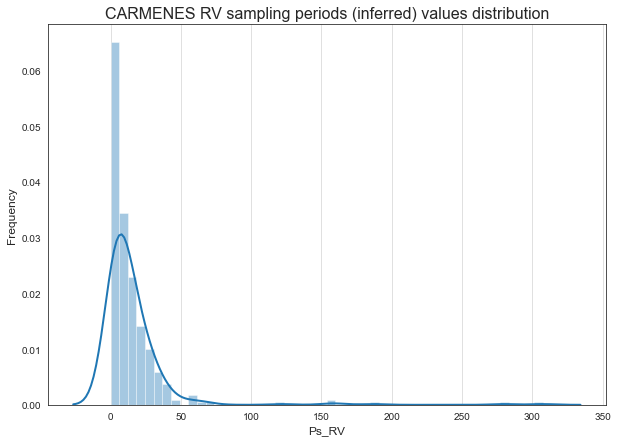

In [85]:
draw_hist(d1=gto['Ps_RV'], d1_label="CARMENES RV sampling periods (inferred)")

**Note:** units for x axis in the above figure are $d$.

In [86]:
gto['Ps_RV'].describe()

count    355.000000
mean      15.626037
std       28.637514
min        0.003170
25%        3.504135
50%        8.474980
75%       18.048045
max      307.604870
Name: Ps_RV, dtype: float64

In [87]:
gto['Ps_RV']. mean()

15.626037098594587

In [88]:
gto['Ps_RV']. median()

8.474979999940842

**OBSERVATION:** There seems to be great differences between the inferred sampling periods for the different RV curves, so we probably need to fit a distribution to simulate this.

[distfit] >fit..
[distfit] >transform..
[distfit] >[norm      ] [0.00 sec] [RSS: 0.0034329] [loc=15.626 scale=28.597]
[distfit] >[expon     ] [0.00 sec] [RSS: 0.0001787] [loc=0.003 scale=15.623]
[distfit] >[pareto    ] [0.05 sec] [RSS: 0.0000305] [loc=-35.552 scale=35.519]
[distfit] >[dweibull  ] [0.04 sec] [RSS: 0.0009912] [loc=4.990 scale=11.811]
[distfit] >[t         ] [0.02 sec] [RSS: 0.0012804] [loc=8.314 scale=6.804]
[distfit] >[genextreme] [0.06 sec] [RSS: 0.0002500] [loc=5.559 scale=5.677]
[distfit] >[gamma     ] [0.04 sec] [RSS: 0.0056998] [loc=0.003 scale=3.513]
[distfit] >[lognorm   ] [0.02 sec] [RSS: 0.0001442] [loc=-0.353 scale=8.554]
[distfit] >[beta      ] [0.06 sec] [RSS: 0.0001396] [loc=0.003 scale=7458.622]
[distfit] >[uniform   ] [0.00 sec] [RSS: 0.0057606] [loc=0.003 scale=307.602]
[distfit] >[loggamma  ] [0.04 sec] [RSS: 0.0036263] [loc=-12136.421 scale=1559.860]
[distfit] >Compute confidence interval [parametric]
[distfit] >plot..


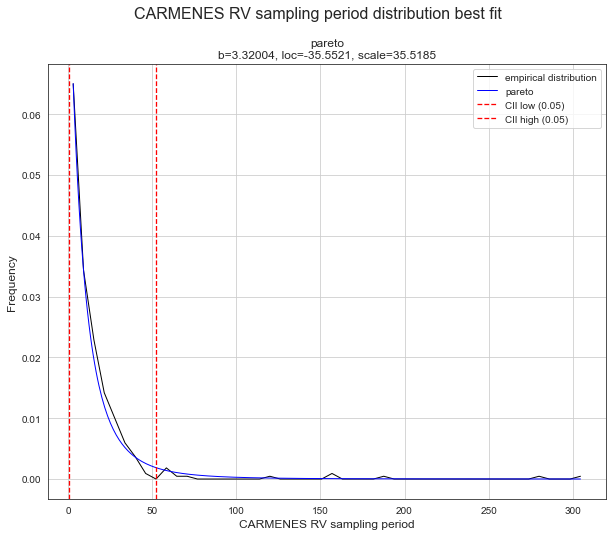

In [89]:
# Initialize the model:
dist = distfit()
# Fit the data:
dist.fit_transform(gto['Ps_RV'])
# Plot results:
dist.plot()
plt.suptitle("CARMENES RV sampling period distribution best fit", fontsize=16)
plt.xlabel("CARMENES RV sampling period", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.show();

In [90]:
# Generate a new sample:
repro_ps = dist.generate(n=len(gto['Ps_RV']), random_state=RANDOM_STATE)

[distfit] >Generate 355 pareto distributed samples with fitted params (3.3200397810070044, -35.552056176575654, 35.51852042528611).


stat=0.829, p=0.408
Probably the same distribution


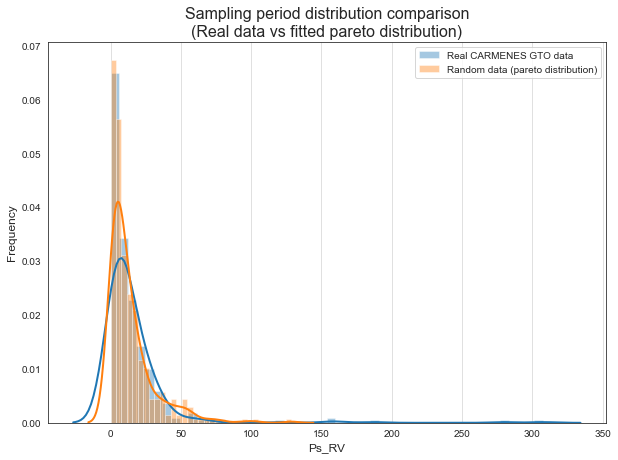

In [91]:
# Compare real and random sample:
compare_dist(gto['Ps_RV'], repro_ps,
             "Real CARMENES GTO data", "Random data (%s distribution)" %dist.model['name'],
             fig_title="Sampling period distribution comparison\n(Real data vs fitted %s distribution)" \
                 %dist.model['name'],
             varname="CARMENES RV curve sampling period",
             fig_filename=IMAGE_FOLDER + "SyntheticDataset_07_04_CARMENES_RV_SamplingPeriod_distfit.png")


**OBSERVATION:** this pareto distribution approximation seems fine.

In [92]:
group = "RV"
variable = "samplingperiodRV"
d_model = dist.model
filename = group + "_" + variable +"_All_GTO_dist.pickle"
fit_dist = fit_dist.append({'Group': group,
                            'Variable': variable,
                            'Distribution': d_model,
                            'Dist_file': filename}, ignore_index=True)
if filename is None:
    pass
else:
    dist.save(DIST_FILES_FOLDER + filename)
fit_dist.to_csv(DIST_SUMMARY_FILE, sep=',', decimal='.', index=False)

[pypickle] Pickle file saved: [./DIST_FILES/RV_samplingperiodRV_All_GTO_dist.pickle]
[distfit] >Saving.. True


In [93]:
fit_dist

,Group,Variable,Distribution,Dist_file
0,BENCHMARK,Ps,{'fixed_value': 0.0025},None
1,BENCHMARK,Tobs,{'fixed_value': 0.25},None
2,BENCHMARK,frequency,{'distr': <scipy.stats._continuous_distns.unif...,BENCHMARK_frequency_All_GTO_dist.pickle
3,BENCHMARK,phase,{'distr': <scipy.stats._continuous_distns.unif...,BENCHMARK_phase_All_GTO_dist.pickle
4,BENCHMARK,amplitudeRV,{'distr': <scipy.stats._continuous_distns.unif...,BENCHMARK_amplitudeRV_All_GTO_dist.pickle
5,BENCHMARK,offsetRV,{'distr': <scipy.stats._continuous_distns.logg...,BENCHMARK_offsetRV_All_GTO_dist.pickle
6,BENCHMARK,refepochRV,{'distr': <scipy.stats._continuous_distns.logn...,BENCHMARK_refepochRV_All_GTO_dist.pickle
7,RV,noiseRV,{'distr': <scipy.stats._continuous_distns.beta...,RV_noiseRV_All_GTO_dist.pickle
8,RV,samplingperiodRV,{'distr': <scipy.stats._continuous_distns.pare...,RV_samplingperiodRV_All_GTO_dist.pickle


#### Number of samples for radial velocity curves (based on CARMENES real data)

count    355.000000
mean      51.726761
std       76.276750
min        4.000000
25%       14.000000
50%       29.000000
75%       60.000000
max      764.000000
Name: n_RV, dtype: float64
p = 1.45579e-88
***This distribution does NOT come from a Gaussian distribution(with significance level = 0.999000)


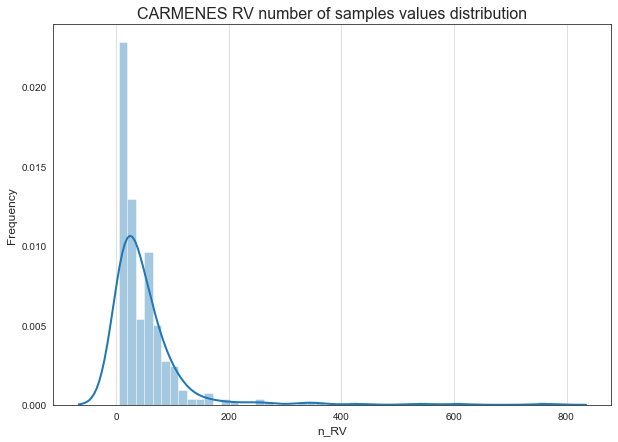

In [94]:
draw_hist(d1=gto['n_RV'], d1_label="CARMENES RV number of samples")

**Note:** units for x axis in the above figure are $d^{-1}$.

In [95]:
gto['n_RV'].describe()

count    355.000000
mean      51.726761
std       76.276750
min        4.000000
25%       14.000000
50%       29.000000
75%       60.000000
max      764.000000
Name: n_RV, dtype: float64

In [96]:
gto['n_RV']. mean()

51.72676056338028

In [97]:
gto['n_RV']. median()

29.0

**OBSERVATION:** Again, there seems to be great differences in the number of samples taken from each GTO object, so a distribution will be used to generate the synthetic datasets.

[distfit] >fit..
[distfit] >transform..
[distfit] >[norm      ] [0.00 sec] [RSS: 0.0004444] [loc=51.727 scale=76.169]
[distfit] >[expon     ] [0.00 sec] [RSS: 0.0000524] [loc=4.000 scale=47.727]
[distfit] >[pareto    ] [0.02 sec] [RSS: 0.0001118] [loc=-0.007 scale=4.007]
[distfit] >[dweibull  ] [0.02 sec] [RSS: 0.0002739] [loc=25.000 scale=33.096]
[distfit] >[t         ] [0.02 sec] [RSS: 0.0002384] [loc=29.989 scale=22.286]
[distfit] >[genextreme] [0.07 sec] [RSS: 0.0000484] [loc=20.692 scale=18.067]
[distfit] >[gamma     ] [0.03 sec] [RSS: 0.0006010] [loc=4.000 scale=22.390]
[distfit] >[lognorm   ] [0.02 sec] [RSS: 0.0000390] [loc=2.443 scale=26.349]
[distfit] >[beta      ] [0.06 sec] [RSS: 0.0000392] [loc=4.000 scale=2004.266]
[distfit] >[uniform   ] [0.0 sec] [RSS: 0.0007639] [loc=4.000 scale=760.000]
[distfit] >[loggamma  ] [0.04 sec] [RSS: 0.0004641] [loc=-34479.036 scale=4350.904]
[distfit] >Compute confidence interval [parametric]
[distfit] >plot..


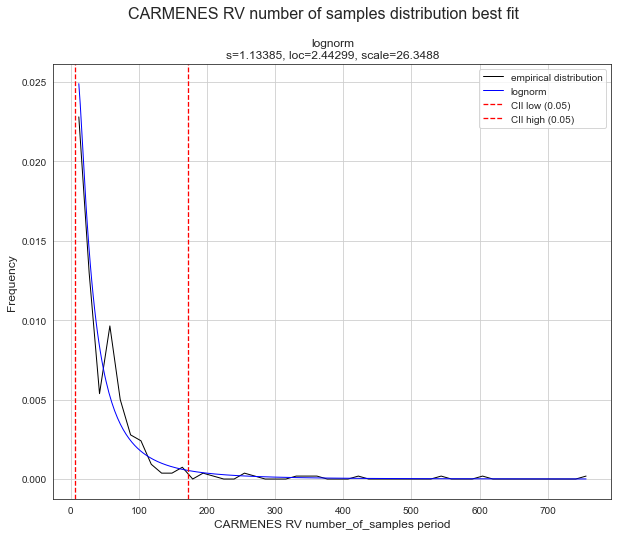

In [98]:
# Initialize the model:
dist = distfit()
# Fit the data:
dist.fit_transform(gto['n_RV'])
# Plot results:
dist.plot()
plt.suptitle("CARMENES RV number of samples distribution best fit", fontsize=16)
plt.xlabel("CARMENES RV number_of_samples period", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.show();

In [99]:
# Generate a new sample:
repro_n = dist.generate(n=len(gto['n_RV']), random_state=RANDOM_STATE)

[distfit] >Generate 355 lognorm distributed samples with fitted params (1.133854037354606, 2.4429937307671574, 26.34882746009161).


stat=0.766, p=0.444
Probably the same distribution


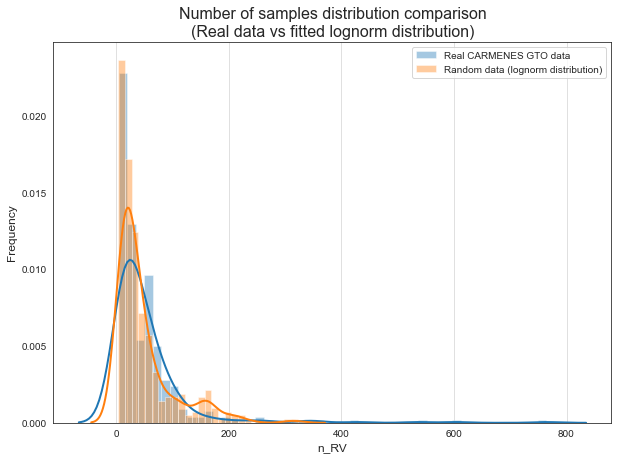

In [100]:
# Compare real and random sample:
compare_dist(gto['n_RV'], repro_n,
             "Real CARMENES GTO data", "Random data (%s distribution)" %dist.model['name'],
             fig_title="Number of samples distribution comparison\n(Real data vs fitted %s distribution)" \
                 %dist.model['name'],
             varname="CARMENES RV curve number of_samples",
             fig_filename=IMAGE_FOLDER + "SyntheticDataset_07_05_CARMENES_RV_NumSamples_distfit.png")


In [101]:
group = "RV"
variable = "numsamplesRV"
d_model = dist.model
filename = group + "_" + variable +"_All_GTO_dist.pickle"
fit_dist = fit_dist.append({'Group': group,
                            'Variable': variable,
                            'Distribution': d_model,
                            'Dist_file': filename}, ignore_index=True)
if filename is None:
    pass
else:
    dist.save(DIST_FILES_FOLDER + filename)
fit_dist.to_csv(DIST_SUMMARY_FILE, sep=',', decimal='.', index=False)

[pypickle] Pickle file saved: [./DIST_FILES/RV_numsamplesRV_All_GTO_dist.pickle]
[distfit] >Saving.. True


In [102]:
fit_dist

,Group,Variable,Distribution,Dist_file
0,BENCHMARK,Ps,{'fixed_value': 0.0025},None
1,BENCHMARK,Tobs,{'fixed_value': 0.25},None
2,BENCHMARK,frequency,{'distr': <scipy.stats._continuous_distns.unif...,BENCHMARK_frequency_All_GTO_dist.pickle
3,BENCHMARK,phase,{'distr': <scipy.stats._continuous_distns.unif...,BENCHMARK_phase_All_GTO_dist.pickle
4,BENCHMARK,amplitudeRV,{'distr': <scipy.stats._continuous_distns.unif...,BENCHMARK_amplitudeRV_All_GTO_dist.pickle
5,BENCHMARK,offsetRV,{'distr': <scipy.stats._continuous_distns.logg...,BENCHMARK_offsetRV_All_GTO_dist.pickle
6,BENCHMARK,refepochRV,{'distr': <scipy.stats._continuous_distns.logn...,BENCHMARK_refepochRV_All_GTO_dist.pickle
7,RV,noiseRV,{'distr': <scipy.stats._continuous_distns.beta...,RV_noiseRV_All_GTO_dist.pickle
8,RV,samplingperiodRV,{'distr': <scipy.stats._continuous_distns.pare...,RV_samplingperiodRV_All_GTO_dist.pickle
9,RV,numsamplesRV,{'distr': <scipy.stats._continuous_distns.logn...,RV_numsamplesRV_All_GTO_dist.pickle


**IMPORTANT NOTE ON CARMENES RV SAMPLING:**

Although we have fitted distributions for the sampling spacing and the number of samples, the approach will be another one: randomly assign real CARMENES RV curves sampling patterns from a pool.

Anyway, we will kept those distributions in the table (and their _pickle_ file) in case they are used in the future.

## Summary

**OBSERVATIONS AND CONCLUSIONS:**
- We have completed the parameter analysis of all CARMENES GTO RV curves (but for 8 curves that gave trouble with periodogram calculation):
  - Benchmark: sampling period, constant at $0.0025\:d$
  - Benchmark: observation period, constant at $0.25\:d$
  - Benchmark: signal frequency, uniform distribution, $f\:\in\:[6.0, 66.0]\:cd^{-1}$
  - Benchmark: phase, uniform distribution, $\delta\:\in\:[0.0, 1.0]$
  - Benchmark (RV): RV amplitude, uniform distribution, $A_{RV}\:\in\:[0.5, 2.0]\:ms^{-1}$
  - Benchmark (RV): RV offset, log-Gamma distribution
  - Benchmark (RV): RV reference epoch, log-normal distribution
  - RV: RV noise, $\beta$ distribution
  - RV: RV sampling period, pareto distribution
  - RV: RV number of samples, log-normal distribution
- All these distributions an a summary have been stored in files, so that they can be later used to generate the synthetic datasets.